# Benchmark on OGB, https://ogb.stanford.edu/docs/home/

In [1]:
import random
import argparse
import configparser
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import scipy
import math

import matplotlib.pyplot as plt


In [2]:
print('sdf')

sdf


In [3]:




def get_spd_matrix(G, S, max_spd=5):
    spd_matrix = np.zeros((G.number_of_nodes(), len(S)), dtype=np.float32)
    for i, node_S in enumerate(S):
        for node, length in nx.shortest_path_length(G, source=node_S).items():
            spd_matrix[node, i] = min(length, max_spd)
    return spd_matrix


class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]

    def add_result(self, run, result):
        assert len(result) == 2
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 0].argmax().item()
            print(f'Run {run + 1:02d}:')
            print(f'Highest Valid: {result[:, 0].max():.2f}')
            print(f'   Final Test: {result[argmax, 1]:.2f}')
        else:
            result = 100 * torch.tensor(self.results)
            best_results = []
            for r in result:
                valid = r[:, 0].max().item()
                test = r[r[:, 0].argmax(), 1].item()
                best_results.append((valid, test))
            best_result = torch.tensor(best_results)
            print(f'All runs:')
            r = best_result[:, 0]
            print(f'Highest Valid: {r.mean():.4f} ± {r.std():.4f}')
            r = best_result[:, 1]
            print(f'   Final Test: {r.mean():.4f} ± {r.std():.4f}')


class SAGEConv(MessagePassing):
    r"""The GraphSAGE operator from the `"Inductive Representation Learning on
    Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        normalize (bool, optional): If set to :obj:`True`, output features
            will be :math:`\ell_2`-normalized, *i.e.*,
            :math:`\frac{\mathbf{x}^{\prime}_i}
            {\| \mathbf{x}^{\prime}_i \|_2}`.
            (default: :obj:`False`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, normalize: bool = False,
                 root_weight: bool = True,
                 bias: bool = True, **kwargs):  # yapf: disable
        kwargs.setdefault('aggr', 'mean')
        super(SAGEConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # Node and edge feature dimensionalites need to match.
        if isinstance(edge_index, Tensor):
            assert edge_attr is not None
            assert x[0].size(-1) == edge_attr.size(-1)
        elif isinstance(edge_index, SparseTensor):
            assert x[0].size(-1) == edge_index.size(-1)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out


    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        return F.relu(x_j + edge_attr)


    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GraphSAGE,self).__init__()
        self.convs = torch.nn.ModuleList()
        
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t, edge_attr, emb_ea):
        edge_attr = torch.mm(edge_attr, emb_ea)
        for conv in self.convs[:-1]:
            x = conv(x, adj_t, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t, edge_attr)  # no nonlinearity
        return x


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)






# Graph Generation

https://networkx.org/documentation/latest/tutorial.html#graph-generators-and-graph-operations



12
index of sample: 0
index of sample: 1
index of sample: 2
index of sample: 3
index of sample: 4
index of sample: 5
index of sample: 6
index of sample: 7
index of sample: 8
index of sample: 9
index of sample: 10
index of sample: 11


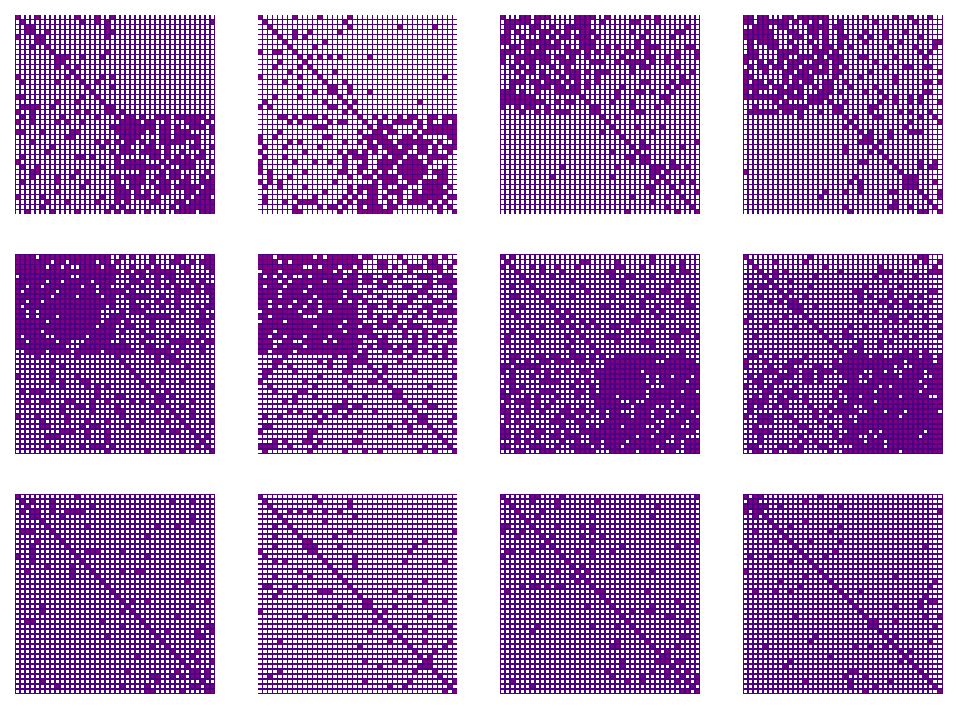

In [4]:
import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# generate ER graphs: G1(N, p1), G2(N, p2), G3(N, p3),G4(N, p4) and then group them into an new G(2N+2N, P)
# objective: learn p1, p2, p3, p4.


def generate_er(graph_num, N, P):
    res= []
    for i in range(graph_num):
        graphs = [nx.to_numpy_array(nx.erdos_renyi_graph(N, p)) for p in P]
        # stack graphs:
        graphh1 = np.hstack([graphs[0], graphs[1]])
        graphh2 = np.hstack([graphs[2], graphs[3]])
        graph = np.vstack([graphh1, graphh2])
        # NOTE: make diagonal all one.
        np.fill_diagonal(graph, 1)
        
        res.append(graph)
    return res

P = [0.15, 0.01, 0.2, 0.5]
N = 20
samples_num = 2

samples = generate_er(samples_num, N, P)
[samples.append(s) for s in generate_er(samples_num, N, P[::-1])]

P = [0.8, 0.4, 0.2, 0.1]
[samples.append(s) for s in generate_er(samples_num, N, P)]
[samples.append(s) for s in generate_er(samples_num, N, P[::-1])]


P = [0.08, 0.02, 0.02, 0.1]
[samples.append(s) for s in generate_er(samples_num, N, P)]
[samples.append(s) for s in generate_er(samples_num, N, P[::-1])]

fig, axes = plt.subplots(3, 4, figsize=(8, 6), dpi=150)

# ax = sns.heatmap(G1, annot=True, annot_kws={'size': 16, 'color': 'black'}, cbar=False,
#                  linecolor='indigo', square=True, linewidths=1,
#                  cmap=ListedColormap(['white', 'purple']))

print(axes.size)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        index =  4*i+j
        print('index of sample:', index)
        sns.heatmap(samples[index], cbar=False, linecolor='indigo', square=True, linewidths=0.3,
                         cmap=ListedColormap(['white', 'purple']), ax=axes[i, j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.axis('off')
# ax.grid()
plt.show()

# Generate ER-graph Dataset: 1. invariant to node; 2. variant to node.
# Generate SBM-graph Dataset: 1. invariant to node; 2. variant to node.



# synthetic dataset generation
---
- a) `permutation invariant`
- b) `permutation variant`
- c) `build pipeline to construct node feautures.`
- d) `build pipeline to construct graph feautures, e.g., laplacian matrix, wavelets, etc.`


In [5]:
# TODO, d), graph feature pipeline.


def add_graph_features(graph_features, cons_fea_func, c_dim=0):
    """input:
            by default, the graph feature at dim=0 of graph_features (numpy) is the original adj matrix.
            graph_features shape: (B, N, N, C), where C is the graph feature number.
            cons_fea_func is the function to construct new graph features with NxN and append to the C-th dimension.
            
            by default, c_dim is 0, use the first adjacency matrix to construct new features. 
       return:
            graph_features, shape will be (B, N, N, C+1). 
    """
    if graph_features.ndim == 3:
        graph_features = np.expand_dims(graph_features, axis=-1)
        
    new_graph_features = []
    for ori_feature in graph_features[..., c_dim]:
        new_graph_features.append(cons_fea_func(ori_feature))
    
    new_graph_features = np.expand_dims(np.stack(new_graph_features, axis=0), axis=-1)
    
    graph_features = np.concatenate([graph_features, new_graph_features], axis=-1)
    
    return graph_features


def composite_node_features(*node_features):
    """ just concatenate the new_node_features with the cur_node_features (N, C1)
        output new node features: (N, C1+C2)
    """
    return np.concatenate(node_features, axis=-1)
    
    

In [6]:
from functools import reduce

def generate_cc_no_degree_corr_samples(cc_range_num=20):
        
    def random_connect_graph(graph_list:list):
        # NOTE: relabeling the nodes.
        new_graphs = []
        np.random.shuffle(graph_list)
        node_idx = 0
        for g in graph_list:
            len_nodes = len(list(g.nodes))
            mapping = {}
            for i in range(len_nodes):
                mapping[i] = i+node_idx
            new_g = nx.relabel_nodes(g, mapping)
            new_graphs.append(new_g)
            node_idx += len_nodes
            
        def connect_graphs(g1, g2):
            n1 = list(g1.nodes)
            n2 = list(g2.nodes)
            e1 = random.choices(n1, k=1)[0]
            e2 = random.choices(n2, k=1)[0]
            g_cur = nx.compose(g1, g2)
            g_cur.add_edge(e1, e2)
            return g_cur
        
        g_all = reduce(connect_graphs, new_graphs)
        
        return g_all
        
        
    def random_add_edges(graph, E=3):
        nodes = list(graph.nodes)
        for i in range(E):
            e = random.sample(nodes, k=2)
            graph.add_edge(*e)
        return graph
        
    cc_range_num = 20
    graphs_cc = []
    for k in range(1, cc_range_num):
        m = cc_range_num - k
        G_tri = [nx.complete_graph(3) for _ in range(k)]
        G_sqr = [nx.cycle_graph(4) for _ in range(m)]
        cur_graphs = [random_connect_graph(utils.flatten_list([G_tri, G_sqr])) for _ in range(5)]
        # repeat for 5 times:
        for _ in range(5):
            [graphs_cc.append(random_add_edges(g, E=3)) for g in cur_graphs]        

    np.random.shuffle(graphs_cc)
    
    
    test_sample_size = int(len(graphs_cc)/3)
    train_adjs, train_y, test_adjs, test_y = [],[],[],[]
    
    for ws in graphs_cc[:-test_sample_size]:
        # TODO: generate some deviation:
        train_adjs.append(ws)
        train_y.append(nx.average_clustering(ws))
        
    for ws in graphs_cc[-test_sample_size:]:
        test_adjs.append(ws)
        test_y.append(nx.average_clustering(ws))
            
    train_adjs = [nx.to_scipy_sparse_matrix(g) for g in train_adjs]
    test_adjs = [nx.to_scipy_sparse_matrix(g) for g in test_adjs]

    train_y = np.stack(train_y, axis=0)
    test_y = np.stack(test_y, axis=0)
    
    return (train_adjs, train_y, test_adjs, test_y)
    

def generate_gnm_samples(each_class_num, node_num=20, edge_nums=[20], sparse=False, std=False):
    
    test_sample_size = int(each_class_num/3)
    train_adjs, train_y, train_label, test_adjs, test_y, teset_label = [],[],[],[],[],[]
    
    # generate train:
    
    for i in range(len(edge_nums)):
        for j in range(each_class_num):
            # TODO: generate some deviation:
            if std:
                devi = np.random.choice([-0.05, 0, 0.05], 1, replace=False)
            else:
                devi=0
            ws=nx.dense_gnm_random_graph(node_num, int(edge_nums[i]+devi))
            train_adjs.append(ws)
            train_y.append(nx.average_clustering(ws))
            train_label.append(i)
            
        for j in range(test_sample_size):
            ws=nx.dense_gnm_random_graph(node_num, int(edge_nums[i]+devi))
            test_adjs.append(ws)
            test_y.append(nx.average_clustering(ws))
            teset_label.append(i)
            
    if sparse:
        train_adjs = [nx.to_scipy_sparse_matrix(g) for g in train_adjs]
        test_adjs = [nx.to_scipy_sparse_matrix(g) for g in test_adjs]
    else:
        train_adjs = [nx.to_numpy_array(g) for g in train_adjs]
        test_adjs = [nx.to_numpy_array(g) for g in test_adjs]
        
        train_adjs = np.stack(train_adjs, axis=0)
        test_adjs = np.stack(test_adjs, axis=0)
        
        
    train_y = np.stack(train_y, axis=0)
    train_label = np.stack(train_label, axis=0)
    
    test_y = np.stack(test_y, axis=0)
    teset_label = np.stack(teset_label, axis=0)
    
    return (train_adjs, train_y, train_label, test_adjs, test_y, teset_label)
    

# generate Watts Strogatz graph
def generate_ws_samples(each_class_num, node_num=20, nei_num=[0.2, 0.5], sparse=False, ps=[0.5, 0.5], std=False):
    
    test_sample_size = int(each_class_num/3)
    train_adjs, train_y, train_label, test_adjs, test_y, teset_label = [],[],[],[],[],[]
    
    # generate train:
    
    for i in range(len(nei_num)):
        for j in range(each_class_num):
            # TODO: generate some deviation:
            if std:
                devi = np.random.choice([-0.05, 0, 0.05], 1, replace=False)
            else:
                devi=0
            ws=nx.watts_strogatz_graph(node_num, int((nei_num[i]+devi)*node_num), ps[i])
            train_adjs.append(ws)
            train_y.append(nx.average_clustering(ws))
            train_label.append(i)
            
        for j in range(test_sample_size):
            ws=nx.watts_strogatz_graph(node_num, int(nei_num[i]*node_num), ps[i])
            test_adjs.append(ws)
            test_y.append(nx.average_clustering(ws))
            teset_label.append(i)
            
    if sparse:
        train_adjs = [nx.to_scipy_sparse_matrix(g) for g in train_adjs]
        test_adjs = [nx.to_scipy_sparse_matrix(g) for g in test_adjs]
    else:
        train_adjs = [nx.to_numpy_array(g) for g in train_adjs]
        test_adjs = [nx.to_numpy_array(g) for g in test_adjs]
        
        train_adjs = np.stack(train_adjs, axis=0)
        test_adjs = np.stack(test_adjs, axis=0)
        
        
    train_y = np.stack(train_y, axis=0)
    train_label = np.stack(train_label, axis=0)
    
    test_y = np.stack(test_y, axis=0)
    teset_label = np.stack(teset_label, axis=0)
    
    return (train_adjs, train_y, train_label, test_adjs, test_y, teset_label)
    


def generate_er_graph_dataset(label_prob,  each_class_num, block_node_num):
    
    test_sample_size = each_class_num/3

    train_data_label = [(generate_er(int(each_class_num),block_node_num, p), [i for _ in range(int(each_class_num))]) for i, p in enumerate(label_prob)]
    train_data = []
    for d in train_data_label:
        for i in range(len(d[0])):
            train_data.append((d[0][i], d[1][i]))
                            
                            
    test_data_label = [(generate_er(int(test_sample_size), block_node_num, p),[i for _ in range(int(each_class_num))]) for i, p in enumerate(label_prob)]
    test_data = []
    for d in test_data_label:
        for i in range(len(d[0])):
            test_data.append((d[0][i], d[1][i]))

    train_adjs = [d[0] for d in train_data]
    train_y =[d[1] for d in train_data]


    test_adjs = [d[0] for d in test_data]
    test_y =[d[1] for d in test_data]
    
    train_adjs = np.stack(train_adjs, axis=0)
    train_y = np.stack(train_y, axis=0)
    test_adjs = np.stack(test_adjs, axis=0)
    test_y = np.stack(test_y, axis=0)
    
    return (train_adjs, train_y, test_adjs, test_y)



# a) permutation invariant

# define label: 0, 1, 2, 3
# 4 blocks:

# b_prob = [1, 0.01, 1, 0.1]
# b_prob2 = [0.01, 0.05, 0.9, 0.8]



# P1 = b_prob # how to decide p??
# P2 = b_prob[::-1] # how to decide p??
# P3 =b_prob2 # how to decide p??
# P4 = b_prob2[::-1] # how to decide p??

# inva_probs = [P1, P2, P3, P4]

# inva_data = generate_er_graph_dataset(inva_probs, 40, 20)

# # b) permutation variant:

# P1 = [0.9, 0.3, 0.3, 0.1]
# P2 = [0.99, 0.9, 0.05, 0.1]
# P3 = [0.8, 0.8, 0.7, 0.1]
# P4 = [0.9, 0.9, 0.8, 0.7]

# va_probs = [P1, P2, P3, P4]
# va_data = generate_er_graph_dataset(va_probs, 40, 20)


# Given dataset, compare with:
* MLP
* CNN
* GNN
* GAE
* GGN

In [18]:
# node or edge feature generation:


def node_degree_feature(adj):
    """ node (weighted, if its weighted adjacency matrix) degree as the node feature.
    """
    if not isinstance(adj, np.ndarray):
        adj = adj.todense()
    degrees = np.sum(adj, axis=1).reshape(adj.shape[0], 1)
    return degrees.astype(np.float32)

def node_allone_feature(adj):
    """return (N, 1) all one node feature
    """
    if not isinstance(adj, np.ndarray):
        adj = adj.todense()
        
    N = adj.shape[0]
    return np.ones(N).reshape(N, 1).astype(np.float32)

def node_index_feature(adj):
    """return (N, 1) node feature, feature equals to the index+1
    """
    N = adj.shape[0]
    return np.arange(1, N+1).reshape(N, 1).astype(np.float32)

def node_deviated_feature(adj):
    N = adj.shape[0]
    block_N = int(N/2)
    fea1 = np.arange(1, block_N+1).reshape(block_N, 1).astype(np.float32)
    fea2 = 3 * np.arange(block_N+1, N+1).reshape(block_N, 1).astype(np.float32)
    return np.concatenate([fea1, fea2], axis=0)
    

# node clustering coefficient


def node_cc_avg_feature(adj):
    N = adj.shape[0]
    g_cur = nx.from_numpy_array(adj)
    feats = nx.average_clustering(g_cur)
    return feats

def node_cc_feature(adj):
    N = adj.shape[0]
    g_cur = nx.from_numpy_array(adj)
    feas_dict = nx.clustering(g_cur)
    feats = []
    for i in range(N):
        feats.append(feas_dict[i])
    feats = np.array(feats).reshape(N, 1).astype(np.float32)
    return feats

In [19]:
import importlib
import models
import utils

from models import BaseGraph, BaseGraphUtils, GraphDataset


importlib.reload(models)
importlib.reload(utils)



def construct_dataset(graph_data, node_features, norm=True, lap_encode=False, \
                      lap_en_dim=8, y_torch_type=torch.LongTensor, sparse=False):
    
    
    train_adjs, train_y, test_adjs, test_y = graph_data
    # construct node features:
    train_node_fea, val_node_fea = node_features
    if norm:
        if sparse:
            mean_y = np.mean(np.concatenate(train_node_fea, axis=0))
            std_y = np.std(np.concatenate(train_node_fea, axis=0))
            scaler = utils.StandardScaler(mean=mean_y, std=std_y)
            train_node_fea = scaler.transform(train_node_fea)
            val_node_fea =  utils.normalize(val_node_fea)
        else:
            mean_y = train_node_fea.mean()
            std_y = train_node_fea.std()
            scaler = utils.StandardScaler(mean=mean_y, std=std_y)
            train_node_fea =  scaler.transform(train_node_fea)
            val_node_fea =  utils.normalize(val_node_fea)
        
    else:
        scaler = None

    train_base_graphs = []
    if sparse:
        for i, adj in enumerate(train_adjs):
            g = models.BaseGraphUtils.from_scipy_coo(adj.tocoo())
            g.set_node_feat(train_node_fea[i])
            train_base_graphs.append(g)

            test_base_graphs = []
            for i, adj in enumerate(test_adjs):
                g = models.BaseGraphUtils.from_scipy_coo(adj.tocoo())
                g.set_node_feat(val_node_fea[i])
                test_base_graphs.append(g)
    else:
        for i, adj in enumerate(train_adjs):
            g = models.BaseGraphUtils.from_numpy(adj)
            g.set_node_feat(train_node_fea[i])
            train_base_graphs.append(g)

        test_base_graphs = []
        for i, adj in enumerate(test_adjs):
            g = models.BaseGraphUtils.from_numpy(adj)
            g.set_node_feat(val_node_fea[i])
            test_base_graphs.append(g)
    
    
    train_dataset = GraphDataset(x=train_base_graphs, y=y_torch_type(train_y))
    test_dataset = GraphDataset(x=test_base_graphs, y=y_torch_type(test_y))

    if lap_encode:
        train_dataset._add_lap_positional_encodings(lap_en_dim)
        test_dataset._add_lap_positional_encodings(lap_en_dim)
    
    return train_dataset, test_dataset, scaler




In [20]:
from models import BaseGraphUtils
# to dataloader:
import models 
importlib.reload(models)

def assemble_dataloader(train_dataset: GraphDataset, test_dataset: GraphDataset, scaler=None, cuda=False, batch_size=20):
    if cuda:
        train_dataset.cuda()
        test_dataset.cuda()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=test_dataset.collate)

    def print_tuple(x):
        if isinstance(x, list) or isinstance(x, tuple):
            adj = x[1]
            x = x[0]
        
    # for x, y in train_dataloader:
    #     print(type(x))
    #     print_tuple(x)
    #     print(y.is_cuda)
    #     break
    
    return (train_dataloader, test_dataloader)

In [21]:
# MLP model
import models
import torch
import torch.nn as nn

from models import BaseGraph, BaseGraphUtils



def mirror_adj(a: torch.Tensor):
    upper_tri = torch.triu(a)
    a1 = (upper_tri+upper_tri.T).fill_diagonal_(1.0)
    lower_tri = torch.tril(a)
    a2 = (lower_tri+lower_tri.T).fill_diagonal_(1.0)
    return a1, a2
    

class DirectModelAdapter(nn.Module):
    def __init__(self, model, pooling, out_dim, node_fea=None):
        super(DirectModelAdapter, self).__init__()
        self.model = model
        self.pooling = pooling
        self.node_fea = node_fea
        self.ln = nn.Linear(model.out_dim, out_dim)
    
    def forward(self, graphs:BaseGraph):
        
        node_x, adj = graphs.get_node_features(), graphs.A
        if self.node_fea is not None:
            node_x = self.node_fea
            
        # print(graphs.graph_type)
        if graphs.graph_type == 'pyg':
            dense_a = graphs.pyg_graph.edge_index.to_dense()
            dense_a1, dense_a2 = mirror_adj(dense_a)
            # TODO: dense to sparse.
            coo1 = BaseGraphUtils.dense_to_coo(dense_a1)
            coo2 = BaseGraphUtils.dense_to_coo(dense_a2)
            edge_index1 = coo1.indices()
            edge_index2 = coo2.indices()
            
        else:
            adj1 = []
            adj2 = []
            for a in adj:
                a1, a2 = mirror_adj(a)
                adj1.append(a1)
                adj2.append(a2)
                
            edge_index1 = torch.stack(adj1, dim=0)
            edge_index2 = torch.stack(adj2, dim=0)
        
        out = self.model(node_x, edge_index1, edge_index2, graphs)
        out = self.pooling(out)
        out = self.ln(out)
        return out

        
class GNNModelAdapter(nn.Module):
    def __init__(self, model, pooling, out_dim, node_fea=None, mid_fea=False):
        super(GNNModelAdapter, self).__init__()
        self.model = model
        
        self.mid_fea = mid_fea
        self.pooling = pooling
        self.node_fea = node_fea
        self.ln = nn.Linear(model.out_dim, out_dim)
        
    def forward(self, graphs:BaseGraph):
        node_x, adj = graphs.get_node_features(), graphs.A
        if self.node_fea is not None:
            node_x = self.node_fea
            
        if graphs.graph_type == 'pyg' or graphs.graph_type == 'coo':
            edge_indices = graphs.get_edge_index()
            mid_feature = self.model(node_x, edge_indices, graphs=graphs)
        else:
            mid_feature = self.model(node_x, adj, graphs)
            
        out = self.pooling(mid_feature, graphs.pyg_graph.batch) if self.pooling is not None else mid_feature
        out = self.ln(out)
        if self.mid_fea:
            return out, mid_feature
        else:
            return out

def choose_model(args, name, node_fea_dim=1, graph_fea_dim=1, class_num=6, node_num=20,
                 out_mid_fea=False, node_wise=False):
    import importlib
    
    # import baseline_models.gnn_lspe.nets.OGBMOL_graph_classification.gatedgcn_net as lspe_net
    # import baseline_models.gnn_lspe.layers.gatedgcn_layer as lspe_layers

    import baseline_models.gnn_baselines
    from baseline_models.identity_GNN import IDGNN


    from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool, global_sort_pool
    
    importlib.reload(models)
    
    
    N = node_num
    if name =='mlp':
        my_model = models.ClassPredictor(N*N, 64, class_num, 3, dropout=0.6)
    elif name == 'cnn':
        my_model = models.SimpleCNN(graph_fea_dim, 64, class_num, dropout=0.6)
    elif name == 'cnn_big':
        my_model = models.SimpleCNN(graph_fea_dim, 64, class_num, dropout=0.6, kernelsize=(11, 11))
    elif name == 'gnn':
        # pool =  models.GateGraphPooling(None, N = N)
        pool = global_mean_pool
        layer_num = 2
        my_model = GNNModelAdapter(models.MultilayerGNN(layer_num, node_fea_dim, 64, 32, dropout=0.6), pool, class_num)
    elif name == 'gin':
        # pool =  models.GateGraphPooling(None, N = N)
        if node_wise:
            pool = None
        else:
            pool = models.MeanPooling()
            # pool = global_mean_pool
        layer_num = 3
        my_model = GNNModelAdapter(models.GINNet(args, node_fea_dim, 64, 32, 3, dropout=0.6), pool, class_num, mid_fea=out_mid_fea)
    elif name == 'sparse_gin':
        if node_wise:
            pool = None
        else:
            pool = global_mean_pool
            # pool = global_mean_pool
        layer_num = 3
        my_model = GNNModelAdapter(models.LSDGINNet(args, node_fea_dim, 64, 32, 3, dropout=0.6, bi=False), pool, class_num, mid_fea=out_mid_fea)
    elif name == 'gin_direc':
        pool =  models.GateGraphPooling(None, N = N)
        layer_num = 3
        di_model = models.DiGINNet(args, node_fea_dim, 64, 32, 3, dropout=0.6)
        my_model = DirectModelAdapter(di_model, pool, class_num)
    elif name == 'lsd_gin':
        pool = global_mean_pool
        pool = global_add_pool
        layer_num = 3
        di_model = models.LSDGINNet(args, node_fea_dim, 64, 32, 3, dropout=0.6)
        my_model = DirectModelAdapter(di_model, pool, class_num)
    
    elif name == 'idgnn':
        pool = global_add_pool
        layer_num = 3
        idgnn_model = IDGNN(args, node_fea_dim, 64, 32, layer_num)
        my_model = GNNModelAdapter(idgnn_model, pool, class_num, mid_fea=out_mid_fea)
    elif name == 'lspe':
        pe_init = 'lap_pe'
        pos_enc_dim = 8
        in_dim = node_fea_dim
        hid_dim = 64
        out_dim = 32
        layer_num= 3
        lspe_model = lspe_net.ReGatedGCNNet(pe_init, pos_enc_dim, in_dim,
                                       hid_dim,out_dim,layer_num=layer_num)
        
        pool =  models.GateGraphPooling(None, N = N)
        my_model = GNNModelAdapter(lspe_model, pool, class_num)
        
    my_model.cuda()
    return my_model

# Define Training function

In [11]:

proj_path = '/li_zhengdao/github/generativegnn'

from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns



class GraphEvaluator:
    def __init__(self):
        pass
    
    def evaluate(self, preds, labels, loss):
        raise NotImplementedError
    
    def statistic(self, epoch):
        raise NotImplementedError


class SimpleEvaluator(GraphEvaluator):
    def __init__(self, args, is_regression=False):
        super(SimpleEvaluator, self).__init__()
        self.args = args
        self.metrics = defaultdict(list)
        self.preds = []
        self.labels = []
        self.epoch_loss = []
        self.mean_metrics = defaultdict(list)
        self.total_metrics = {}
        self.is_regression = is_regression
        
    def evaluate(self, preds, labels, loss, null_val=0.0):
        
        if self.is_regression:
            preds_b = preds
            if np.isnan(null_val):
                mask = ~torch.isnan(labels)
            else:
                mask = (labels != null_val)
                mask = mask.float()
                mask /= torch.mean(mask)
                # handle all zeros.
                mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
                mse = (preds - labels) ** 2
                mae = loss
                mape = mae / labels
                mae, mape, mse = [mask_and_fillna(l, mask) for l in [mae, mape, mse]]
                rmse = torch.sqrt(mse)
                
                self.metrics['mae'].append(mae.item())
                self.metrics['mape'].append(mape.item())
                self.metrics['rmse'].append(rmse.item())
                self.metrics['loss'].append(loss)
            
        else:
            num = preds.size(0)
            # print('evl preds shape:', preds.shape, labels.shape)
            preds_b = preds.argmax(dim=1).squeeze()
            labels = labels.squeeze()
            ones = torch.zeros(num)
            ones[preds_b == labels] = 1
            acc = torch.sum(ones) / num
                
            mi_f1, ma_f1, weighted_f1 = utils.cal_f1(preds_b.cpu().detach().numpy(), labels.cpu().detach().numpy())
            self.metrics['micro_f1'].append(mi_f1)
            self.metrics['macro_f1'].append(ma_f1)
            self.metrics['weighted_f1'].append(weighted_f1)
            self.metrics['acc'].append(acc.numpy())
            self.metrics['loss'].append(loss)
        
        self.preds.append(preds_b)
        self.labels.append(labels)
        
        
    def statistic(self, epoch):
        for k, v in self.metrics.items():
            self.mean_metrics[k].append(np.mean(v))
            
        self.metrics = defaultdict(list)
            
    def eval_on_test(self):
        if self.is_regression:
            preds = torch.cat(self.preds, dim=0)
            labels = torch.cat(self.labels, dim=0)
            mask = (labels != 0.0)
            mask = mask.float()
            mask /= torch.mean(mask)
            # handle all zeros.
            mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
            mse = (preds - labels) ** 2
            mae = torch.abs(preds - labels)
            mape = mae / labels
            mae, mape, mse = [mask_and_fillna(l, mask) for l in [mae, mape, mse]]
            rmse = torch.sqrt(mse)
            
            self.metrics['mae'].append(mae)
            self.metrics['mape'].append(mape)
            self.metrics['rmse'].append(rmse)
            
        else:
            preds = torch.cat(self.preds, dim=0)
            labels = torch.cat(self.labels, dim=0)
            mi_f1, ma_f1, weighted_f1 = utils.cal_f1(preds.cpu().detach().numpy(), labels.cpu().detach().numpy())
            self.total_metrics['micro_f1'] = mi_f1
            self.total_metrics['macro_f1'] = ma_f1
            self.total_metrics['weighted_f1'] = weighted_f1
    
    def print_info(self):
        micro_f1 = self.metrics[-1]['micro_f1']
        macro_f1 = self.metrics[-1]['macro_f1']
        weighted_f1 = self.metrics[-1]['weighted_f1']
        acc = self.metrics[-1]['acc']
        loss =  self.metrics[-1]['loss']
        print('------------- metrics -------------------')
        print(f'micro f1: {"%.3f" % micro_f1}, macro f1:  {"%.3f" % macro_f1},weighted f1:  {"%.3f" % weighted_f1},\n \
            acc:  {"%.3f" % acc}, loss: {"%.3f" % loss}')
        
    
        
    def plot_metrics(self):
        
        preds = torch.cat(self.preds, dim=0)
        labels = torch.cat(self.labels, dim=0)
        
        if not self.is_regression:
            plot_confuse_matrix(preds, labels)
        
        loss_list = self.mean_metrics['loss']
        
        plot_loss(loss_list)
        
        
def base_args():
    args = utils.get_common_args()
    args = args.parse_args([])
    
    args.debug = True
    utils.DLog.init(args)
    args.lr=0.00004
    args.cuda=True
    return args


def training(epochs, trainer, train_evaluator, test_evaluator:SimpleEvaluator, train_dataloader, 
             test_dataloader, cuda=True):
    for e in range(epochs):
        for x, y in train_dataloader:
            if cuda:
                x = x.cuda()
                y = y.cuda()
            y = y.squeeze()
            loss, pred_y = trainer.train(x, y)
            train_evaluator.evaluate(pred_y, y, loss)
        
        for x, y in test_dataloader:
            if cuda:
                x = x.cuda()
                y = y.cuda()
            y = y.squeeze()
            loss, pred_y = trainer.eval(x, y)
            test_evaluator.evaluate(pred_y, y, loss)
        
        train_evaluator.statistic(e)
        test_evaluator.statistic(e)
        
    train_evaluator.eval_on_test()
    test_evaluator.eval_on_test()
        
      
def plot_confuse_matrix(preds, labels):
    
    sns.set()
    fig = plt.figure(figsize=(3, 1.5),tight_layout=True, dpi=150)
    ax = fig.gca()
    gts = [int(l) for l in labels]
    preds = [int(l) for l in preds]
    
    label_names = list(set(preds))
    C2= np.around(confusion_matrix(gts, preds, labels=label_names, normalize='true'), decimals=2)

    # from confusion to ACC, micro-F1, macro-F1, weighted-f1.
    print('Confusion:', C2)
    font_size = 6
    p = sns.heatmap(C2, cbar=False, annot=True, ax=ax, cmap="YlGnBu", square=False, annot_kws={"size":font_size},
        yticklabels=label_names,xticklabels=label_names)
    
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    plt.tight_layout()

            

def plot_loss(loss):
    fig = plt.figure(figsize=(3, 1.5), tight_layout=True, dpi=150)
    plt.plot(loss)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

def mask_and_fillna(loss, mask):
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)


class MAECal(nn.Module):
    def __init__(self):
        super(MAECal, self).__init__()
        pass
    
    def forward(self, pred_y, labels, null_val=0.0):
        
        labels = labels.squeeze()
        if np.isnan(null_val):
            mask = ~torch.isnan(labels)
        else:
            mask = (labels != null_val)
        
        mask = mask.float()
        mask /= torch.mean(mask)
        mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)

        mae = torch.abs(pred_y - labels)
        mae = mask_and_fillna(mae, mask)
        return mae

class CELossCal(nn.Module):
    def __init__(self, weights=None):
        super(CELossCal, self).__init__()
        self.crite = nn.CrossEntropyLoss(weight=weights)
        
    def forward(self, pred_y, y):
        return self.crite(pred_y, y)
 


In [12]:
import utils
import importlib
importlib.reload(utils)

# use MLP to trian:

def train_mlp(train_loader, test_loader, epoch=200, plot=False):
    args = base_args()
    mlp_model = choose_model('mlp')

    args.debug = False
    utils.DLog.init(args)
    # opt = optim.Adam(mlp_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    opt = optim.SGD(mlp_model.parameters(), lr=0.001)
    ce_loss_cal = CELossCal()

    trainer = utils.Trainer(mlp_model, optimizer=opt, loss_cal=ce_loss_cal)
    train_sim_evl= SimpleEvaluator(args)
    test_sim_evl= SimpleEvaluator(args)

    training(epoch, trainer, train_sim_evl, test_sim_evl, train_loader, test_loader)

    if plot:
        train_sim_evl.plot_metrics()
        test_sim_evl.plot_metrics()
    
    return train_sim_evl, test_sim_evl

# _,_ = train_mlp(va_train_dataloader, va_test_dataloader, epoch=1, plot=True)
# train_mlp(inva_train_dataloader, inva_test_dataloader, True)



In [13]:
import utils
import importlib
importlib.reload(utils)



def train_cnn(train_loader, test_loader, epoch=200, plot=False, cnn_name='cnn', graph_fea_dim=1):
# use CNN to trian:
    args = base_args()
    cnn_model = choose_model(cnn_name, graph_fea_dim=graph_fea_dim)
    # opt = optim.Adam(mlp_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    opt = optim.SGD(cnn_model.parameters(), lr=0.0001)
    ce_loss_cal = CELossCal()

    trainer = utils.Trainer(cnn_model, optimizer=opt, loss_cal=ce_loss_cal)
    train_sim_evl= SimpleEvaluator(args)
    test_sim_evl= SimpleEvaluator(args)

    training(epoch, trainer, train_sim_evl, test_sim_evl,train_loader,test_loader)
    if plot:
        train_sim_evl.plot_metrics()
        test_sim_evl.plot_metrics()
        
    return train_sim_evl, test_sim_evl
    
# _, _ = train_cnn(va_train_dataloader, va_test_dataloader, epoch=100, plot=True)
# train_cnn(inva_train_dataloader, inva_test_dataloader, True)

In [14]:
# GNN:
import utils
import importlib
importlib.reload(utils)
import models
importlib.reload(models)

def train_gnn(args, train_loader, test_loader, gnn_name='gnn', epoch=200, plot=False, node_fea_dim=1,
              class_num=6, node_num=20, **xargs):
        
    def get_value(key, default=None):
        return xargs[key] if key in xargs else default
    
    # use GNN to trian:
    args.debug = False
    utils.DLog.init(args)
    
    is_node_wise = get_value('is_node_wise', False)
    is_regression = get_value('is_regression', False)
    scaler = get_value('scaler')
    opt = get_value('opt', 'sgd')
    lr = xargs['lr'] if 'lr' in xargs else 0.0002
    
    
    
    gnn_model = choose_model(args, gnn_name, node_fea_dim=node_fea_dim, class_num=class_num,
                             node_num=node_num,
                             node_wise=is_node_wise)
    if opt == 'adam':
        opt = optim.Adam(gnn_model.parameters(), lr=lr, weight_decay=args.weight_decay)
    else:
        opt = optim.SGD(gnn_model.parameters(), lr=lr)
        
    
    
    loss_cal = get_value('loss_cal', None)
    if loss_cal is None:
        loss_cal =  MAECal() if is_regression else CELossCal()
    elif loss_cal == 'mse':
        loss_cal = nn.MSELoss()
    elif loss_cal == 'mae':
        loss_cal = MAECal()
        

    trainer = utils.Trainer(gnn_model, optimizer=opt, loss_cal=loss_cal, scaler=scaler)
    train_sim_evl= SimpleEvaluator(args, is_regression=is_regression)
    test_sim_evl= SimpleEvaluator(args,is_regression=is_regression)

    training(epoch, trainer, train_sim_evl, test_sim_evl, train_loader, test_loader)

    if plot:
        train_sim_evl.plot_metrics()
        test_sim_evl.plot_metrics()
        
    return train_sim_evl, test_sim_evl, gnn_model

# train_gnn(va_train_dataloader, va_test_dataloader, True)
# train_gnn(inva_train_dataloader, inva_test_dataloader, True)

# 6 classification dataset generation !!!

In [21]:
# make probabities in two corners from very similar to very different in a range 0 - 1:
# a) permutation invariant
# 4 blocks:

p_max = .5
p_min = .01
prob1 = [p_max, p_min, p_max, p_min]
prob2 = [0.01, p_max, 0.01, p_max]
prob3 = [p_max, p_max, 0.01, 0.01]
prob4 = [0.01, 0.01, p_max, p_max]

# TODO add symmetric probs
# 
prob5 = [p_max, .01, .01, p_max]
prob6 = [0.01, p_max, p_max, .01]


each_class_num = 40
block_node_num = 20
class_num = 6


data_sim = []

for i in range(24):
    prob1[1] = prob1[3] = prob1[3] + 0.02
    prob2[0] = prob2[2] = prob2[2] + 0.02
    prob3[2] = prob3[3] = prob3[3] + 0.02
    prob4[0] = prob4[1] = prob4[1] + 0.02
    
    prob5[1] = prob5[2] = prob5[2] + 0.02
    prob6[0] = prob6[3] = prob6[3] + 0.02

    probs = [prob1, prob2, prob3, prob4, prob5,prob6]
    
    data_sim.append(generate_er_graph_dataset(probs, each_class_num, block_node_num))

NameError: name 'generate_er' is not defined

In [17]:
def generate_node_feature(all_data, node_cons_func, sparse=False):
    train_node_feas = [] # train, val
    test_node_feas = [] # train, val
    for train_adj ,_, test_adj, _ in all_data:
        if sparse:
            train_node_feas.append( [node_cons_func(adj) for adj in train_adj])
            test_node_feas.append( [node_cons_func(adj) for adj in test_adj])
        else:
            train_node_feas.append(np.stack([node_cons_func(adj) for adj in train_adj], axis=0))
            test_node_feas.append(np.stack([node_cons_func(adj) for adj in test_adj], axis=0))
        
    return train_node_feas, test_node_feas    

# Generate ER graph node feature

In [200]:
# construct node features:
train_node_index_feas, test_node_index_feas = generate_node_feature(data_sim, node_index_feature)
train_node_degree_feas, test_node_degree_feas = generate_node_feature(data_sim, node_degree_feature)
train_node_allone_feas, test_node_allone_feas = generate_node_feature(data_sim, node_allone_feature)
train_node_std_feas, test_node_std_feas = generate_node_feature(data_sim, node_deviated_feature)


NameError: name 'data_sim' is not defined

# CCA function definitions

In [16]:

def ppp(*values: object):
    print('------------------------------')
    print(*values)
    

def get_mid_feat(cur_model, dataloader, pooled=False, prediction=False, logit=True):
    
    
    new_loader = DataLoader(dataloader.dataset, batch_size=10, shuffle=False, collate_fn=dataloader.dataset.collate)

    if prediction:
        cur_model.mid_fea = False
        cur_model.eval()
        
        preds = []
        for x, _ in new_loader:
            x = x.cuda()
            out = cur_model(x)
            preds.append(out)
        
        preds = torch.cat(preds, dim=0).detach().cpu().numpy()
        if logit:
            print('preds shape', preds.shape)
        return preds
    else:
        cur_model.mid_fea = True
        cur_model.eval()
        
        mid_feas = []
        for x, _ in new_loader:
            x = x.cuda()
            _, mid_f_train = cur_model(x)
            mid_feas.append(mid_f_train)
        mid_feas = torch.cat(mid_feas, dim=0)
        if pooled:
            mid_feas = cur_model.pooling(mid_feas).detach().cpu().numpy()
        if logit:
            print('mid_feas shape', mid_feas.shape)
        return mid_feas



def get_cca_corr(fea1, fea2, CCA=True):
    if not isinstance(fea1, np.ndarray):
        fea1 = fea1.cpu().numpy()
    if not isinstance(fea2, np.ndarray):
        fea2 = fea2.cpu().numpy()
    
    if CCA:
        from sklearn.cross_decomposition import CCA
        n_compo = 1
        cca = CCA(n_components=n_compo, scale=True, max_iter=500, tol=1e-06, copy=True)
        cca.fit(fea1, fea2)
        X_c, Y_c = cca.transform(fea1, fea2)
        r2 = cca.score(fea1, fea2)
        print('r2:',r2)
    else:
        X_c = fea1
        Y_c = fea2
    # cal correaltion:
    from scipy import stats
    corr = stats.pearsonr(X_c.squeeze(), Y_c.squeeze())
    print(corr)


# Generate SBM WS graph node feature

In [21]:
# 4 blocks.
ps = [0.5]
neighbor_list=[0.3]
#     return (train_adjs, train_y, train_label, test_adjs, test_y, teset_label)
b1 = generate_ws_samples(60, nei_num=neighbor_list, ps=ps)

def compose_4blocks(graphs):
        
    graphh1 = np.concatenate([graphs[0], graphs[1]], axis=-1)
    graphh2 = np.concatenate([graphs[2], graphs[3]],axis=-1)
    graph = np.concatenate([graphh1, graphh2],axis=-2)
    print('graph shape:', graph.shape)
    return graph


b1_adjs_train = compose_4blocks([b1[0], b1[0], b1[0], b1[0]])
b1_adjs_test = compose_4blocks([b1[3], b1[3], b1[3], b1[3]])


# 4 blocks.
neighbor_list=[0.5]
#     return (train_adjs, train_y, train_label, test_adjs, test_y, teset_label)
bhigh = generate_ws_samples(60, nei_num=neighbor_list, ps=ps)

neighbor_list=[0.2]
blow = generate_ws_samples(60, nei_num=neighbor_list, ps=ps)


b2_adjs_train = compose_4blocks([bhigh[0], blow[0], blow[0], blow[0]])
b2_adjs_test = compose_4blocks([bhigh[3], blow[3], blow[3], blow[3]])


# check degree and CC:
b1_degree = generate_node_feature([(b1_adjs_train, None, b1_adjs_test, None)], node_degree_feature)
b2_degree = generate_node_feature([(b2_adjs_train, None, b2_adjs_test, None)], node_degree_feature)

b1_degree_avg = (np.mean(b1_degree[0][0], axis=1), np.mean(b1_degree[1][0], axis=1))
b2_degree_avg = (np.mean(b2_degree[0][0], axis=1), np.mean(b2_degree[1][0], axis=1))

# print(b1_degree[0][0].shape) # BN1
b1_cc_avg =  generate_node_feature([(b1_adjs_train, None, b1_adjs_test, None)] ,node_cc_avg_feature)
b2_cc_avg =  generate_node_feature([(b2_adjs_train, None, b2_adjs_test, None)] ,node_cc_avg_feature)

graph shape: (60, 40, 40)
graph shape: (20, 40, 40)
graph shape: (60, 40, 40)
graph shape: (20, 40, 40)


# b3,b4

In [108]:
# * based on above figure, pick same horizontal points
# - blueK=0.2, p=0.3, orangeK=0.25, p=0.35, greenK=0.3, p= 0.6,
# - redK=0.35,p=0.6, orangek=0.25, p=0.3 (try this first)

Ks=[0.2, 0.25]
ps = [0.4, 0.6]
b3 = generate_ws_samples(30, node_num=40, nei_num=Ks, ps=ps)
b3_adjs_train = b3[0]
b3_adjs_test = b3[3]

Ks=[0.3, 0.4]
ps=[0.2, 0.4]
b4 = generate_ws_samples(30, node_num=40, nei_num=Ks, ps=ps)
b4_adjs_train = b4[0]
b4_adjs_test = b4[3]

# check degree and CC:
b3_degree = generate_node_feature([(b3[0], None, b3[3], None)], node_degree_feature)
b4_degree = generate_node_feature([(b4[0], None, b4[3], None)], node_degree_feature)

b3_degree_avg = (np.mean(b3_degree[0][0], axis=1), np.mean(b3_degree[1][0], axis=1))
b4_degree_avg = (np.mean(b4_degree[0][0], axis=1), np.mean(b4_degree[1][0], axis=1))

# print(b1_degree[0][0].shape) # BN1
b3_cc_avg =  generate_node_feature([(b3[0], None, b3[3], None)] ,node_cc_avg_feature)
b4_cc_avg =  generate_node_feature([(b4[0], None, b4[3], None)] ,node_cc_avg_feature)

(60, 1)
(60, 1)


Text(0.5, 1.0, 'b4 mean cc')

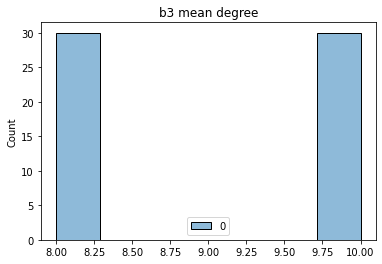

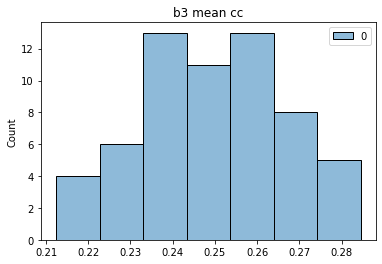

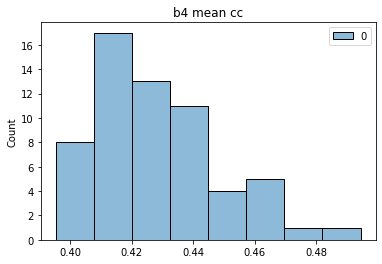

In [109]:
print(b3_degree_avg[0].shape)
print(b4_degree_avg[0].shape)
plt.figure()
sns.histplot(b3_degree_avg[0])
plt.title('b3 mean degree')


plt.figure()
sns.histplot(b3_cc_avg[0][0].reshape(-1, 1))
plt.title('b3 mean cc')

# plt.figure()
# sns.histplot(b4_degree_avg[0])
# plt.title('b4 mean degree')


plt.figure()
sns.histplot(b4_cc_avg[0][0].reshape(-1, 1))
plt.title('b4 mean cc')


In [110]:
# construct degree b1b2 dataloader:
b1b2_adjs_train = np.concatenate([b1_adjs_train, b2_adjs_train], axis=0)
b1b2_adjs_test = np.concatenate([b1_adjs_test, b2_adjs_test], axis=0)

b1b2_labels_degree_train = np.concatenate([b1_degree_avg[0], b2_degree_avg[0]], axis=0)
b1b2_labels_degree_test = np.concatenate([b1_degree_avg[1], b2_degree_avg[1]], axis=0)

b1b2_dataset_oth_degree = (b1b2_adjs_train,b1b2_labels_degree_train, b1b2_adjs_test, b1b2_labels_degree_test)


# construct degree b3b4 dataloader:
b3b4_adjs_train = np.concatenate([b3_adjs_train, b4_adjs_train], axis=0)
b3b4_adjs_test = np.concatenate([b3_adjs_test, b4_adjs_test], axis=0)

b3b4_labels_degree_train = np.concatenate([b3_degree_avg[0], b4_degree_avg[0]], axis=0)
b3b4_labels_degree_test = np.concatenate([b3_degree_avg[1], b4_degree_avg[1]], axis=0)

b3b4_dataset_oth_degree = (b3b4_adjs_train,b3b4_labels_degree_train, b3b4_adjs_test, b3b4_labels_degree_test)


def get_oth_dataloaders(adjs_train, adjs_test, oth_dataset):
    allone_train,  allone_test=  generate_node_feature([(adjs_train, None, adjs_test, None)] ,node_allone_feature)

    # add Gaussion noise:
    allone_train[0] = 0.1 * allone_train[0] + np.random.random(size=allone_train[0].shape)
    allone_test[0] = 0.1 * allone_test[0] + np.random.random(size=allone_test[0].shape)

    oth_dataloaders = []
    train_dataset, test_dataset, scaler = construct_dataset(oth_dataset,
                                                    (allone_train[0], allone_test[0]), y_torch_type=torch.FloatTensor)
    oth_dataloaders.append(assemble_dataloader(train_dataset, test_dataset))
    return oth_dataloaders, allone_train, allone_test


b1b2_oth_degree_dataloaders, b1b2_allone_train_feats,  b1b2_allone_test_feats = get_oth_dataloaders(b1b2_adjs_train, b1b2_adjs_test, b1b2_dataset_oth_degree)
b3b4_oth_degree_dataloaders, b3b4_allone_train_feats,  b3b4_allone_test_feats  = get_oth_dataloaders(b3b4_adjs_train, b3b4_adjs_test, b3b4_dataset_oth_degree)




In [111]:
# construct b1b2 cc dataloader:

def get_cc_dataloaders(adjs_train, adjs_test, cc_avg1, cc_avg2, feat1, feat2):
    labels_cc_train = np.concatenate([cc_avg1[0][0], cc_avg2[0][0]], axis=0)
    labels_cc_test = np.concatenate([cc_avg1[1][0], cc_avg2[1][0]], axis=0)
    dataset_oth_cc = (adjs_train,
                labels_cc_train,
                adjs_test,
                labels_cc_test)

    cc_dataloaders = []
    cc_dataloaders.append(assemble_dataloader(
        *construct_dataset(dataset_oth_cc,
                            (feat1[0], feat2[0]), y_torch_type=torch.FloatTensor)))
    
    return cc_dataloaders

b1b2_oth_cc_dataloaders = get_cc_dataloaders(b1b2_adjs_train, b1b2_adjs_test, b1_cc_avg, b2_cc_avg, 
                                         b1b2_allone_train_feats, b1b2_allone_test_feats)

# construct b3b4 cc dataloader:

b3b4_oth_cc_dataloaders = get_cc_dataloaders(b3b4_adjs_train, b3b4_adjs_test, b3_cc_avg, b4_cc_avg, 
                                         b3b4_allone_train_feats, b3b4_allone_test_feats)


# train ws b1b2 aothnode-wise cc:

In [25]:
# train ws b1b2 aothnode-wise cc:
import utils 
importlib.reload(utils)

args = utils.get_common_args()
args = args.parse_args({})

ws_b1b2_cc_gnn_evls_train = []
ws_b1b2_cc_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task6 = []
for train_dataloader, test_dataloader in ws_b1b2_cc_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.0001, is_regression=True, is_node_wise=False)
    
    gnn_models_task6.append(cur_model)
    ws_b1b2_cc_gnn_evls_train.append(train_evl)
    ws_b1b2_cc_gnn_evls_test.append(test_evl)
    
ws_b1b2_cc_gnn_evls_train[0].plot_metrics()
ws_b1b2_cc_gnn_evls_test[0].plot_metrics()

NameError: name 'ws_b1b2_cc_dataloaders' is not defined

# train ws b1b2 aoth graph-wise degree:

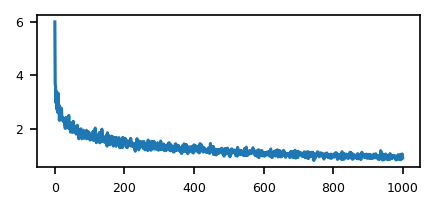

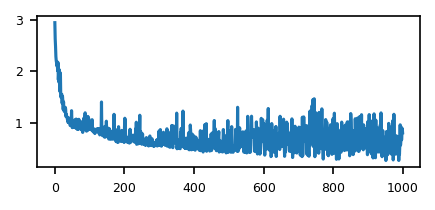

In [31]:
# train ws b1b2 aothnode-wise cc:
import utils 
importlib.reload(utils)

args = utils.get_common_args()
args = args.parse_args({})

ws_b1b2_degree_gnn_evls_train = []
ws_b1b2_degree_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task7 = []
for train_dataloader, test_dataloader in b1b2_oth_degree_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.00002, is_regression=True, is_node_wise=False)
    
    gnn_models_task7.append(cur_model)
    ws_b1b2_degree_gnn_evls_train.append(train_evl)
    ws_b1b2_degree_gnn_evls_test.append(test_evl)
    
ws_b1b2_degree_gnn_evls_train[0].plot_metrics()
ws_b1b2_degree_gnn_evls_test[0].plot_metrics()

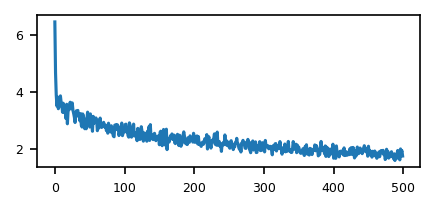

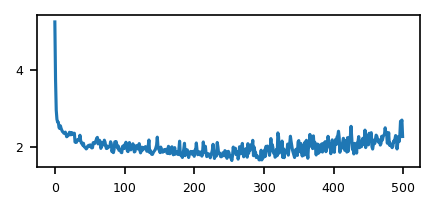

In [26]:
# train ws b1b2 aothnode-wise cc:
import utils 
importlib.reload(utils)

args = utils.get_common_args()
args = args.parse_args({})

ws_b3b4_degree_gnn_evls_train = []
ws_b4b3_degree_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task8 = []
for train_dataloader, test_dataloader in b3b4_oth_degree_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=500,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.00001, is_regression=True, is_node_wise=False)
    
    gnn_models_task8.append(cur_model)
    ws_b3b4_degree_gnn_evls_train.append(train_evl)
    ws_b4b3_degree_gnn_evls_test.append(test_evl)
    
ws_b3b4_degree_gnn_evls_train[0].plot_metrics()
ws_b4b3_degree_gnn_evls_test[0].plot_metrics()


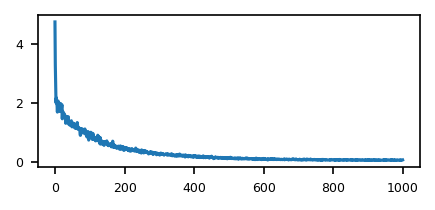

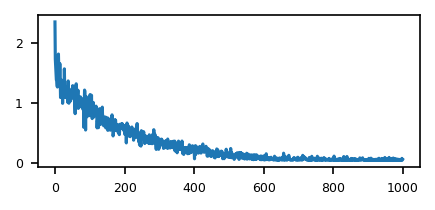

In [27]:
# train ws b1b2 aothnode-wise cc:
import utils 
importlib.reload(utils)

args = utils.get_common_args()
args = args.parse_args({})

ws_b1b2_cc_gnn_evls_train = []
ws_b1b2_cc_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task9 = []
for train_dataloader, test_dataloader in b1b2_oth_cc_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.00001, is_regression=True, is_node_wise=False)
    
    gnn_models_task9.append(cur_model)
    ws_b1b2_cc_gnn_evls_train.append(train_evl)
    ws_b1b2_cc_gnn_evls_test.append(test_evl)
    
ws_b1b2_cc_gnn_evls_train[0].plot_metrics()
ws_b1b2_cc_gnn_evls_test[0].plot_metrics()

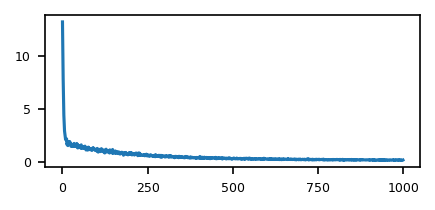

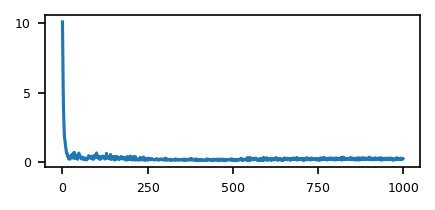

In [112]:
# train ws b1b2 aothnode-wise cc:
import utils 
importlib.reload(utils)

args = utils.get_common_args()
args = args.parse_args({})

ws_b3b4_cc_gnn_evls_train = []
ws_b3b4_cc_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task10 = []
for train_dataloader, test_dataloader in b3b4_oth_cc_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.000005, is_regression=True, is_node_wise=False)
    
    gnn_models_task10.append(cur_model)
    ws_b3b4_cc_gnn_evls_train.append(train_evl)
    ws_b3b4_cc_gnn_evls_test.append(test_evl)
    
ws_b3b4_cc_gnn_evls_train[0].plot_metrics()
ws_b3b4_cc_gnn_evls_test[0].plot_metrics()

In [113]:
# Check the fitness

# b3b4 CC:

# degree:

cur_model = gnn_models_task8[0]
cur_model.mid_fea = False

input_x = None
out_y = None
label_y = None
for x, y in b3b4_oth_degree_dataloaders[0][0]:
    input_x = x
    label_y = y
    x = x.cuda()
    out = cur_model(x)
    print(out.shape)
    out_y = out.cpu()
    break

print(label_y)
print(out_y)


torch.Size([10, 1])
tensor([[16.],
        [12.],
        [10.],
        [ 8.],
        [16.],
        [10.],
        [12.],
        [10.],
        [16.],
        [10.]], device='cuda:0')
tensor([[16.5927],
        [ 8.4726],
        [ 6.2042],
        [ 5.0988],
        [14.8904],
        [ 5.8651],
        [ 8.5867],
        [ 7.0493],
        [16.9120],
        [ 6.8944]], grad_fn=<CopyBackwards>)


# task1 avg degree, ok
# task2 avg CC ok.
# task3 node-wise degree, ok
# task4, node-wise CC, ok
# task5, two label classification ok.
# task6, b1b2, node-wise degree, -> b1b2: same degree, different CC
# task7, b1b2, graph-wise degree 
# task8, b3b4, graph-wise degree,  -> same CC, different degree.
# task9, b1b2, graph-wise CC
# task10, b3b4, graph-wise CC


# WS orthogonal labels b1b2 b3b4 compare CCA corr 

In [1]:


ppp('b1b2 label corr')
get_cca_corr(b1b2_oth_degree_dataloaders[0][0].dataset.y.reshape(-1, 1),
             b1b2_oth_cc_dataloaders[0][0].dataset.y.reshape(-1, 1))

b1b2_oth_labels_cc_train = b1b2_oth_cc_dataloaders[0][0].dataset.y.reshape(-1, 1)

ppp('b3b4 label corr')
get_cca_corr(b3b4_oth_degree_dataloaders[0][0].dataset.y.reshape(-1, 1),
             b3b4_oth_cc_dataloaders[0][0].dataset.y.reshape(-1, 1))

b3b4_oth_labels_cc_train = b3b4_oth_cc_dataloaders[0][0].dataset.y.reshape(-1, 1)


NameError: name 'ppp' is not defined

# WS orthogonal b1b2 b3b4 compare CCA corr 

In [115]:
# GET midfeatures:


# b1b2 features

b1b2_oth_degree_train_feat = get_mid_feat(gnn_models_task7[0], b1b2_oth_degree_dataloaders[0][0], pooled=True, logit=False)
b3b4_oth_degree_train_feat = get_mid_feat(gnn_models_task8[0], b3b4_oth_degree_dataloaders[0][0], pooled=True, logit=False)

b1b2_oth_cc_train_feat = get_mid_feat(gnn_models_task9[0], b1b2_oth_cc_dataloaders[0][0], pooled=True, logit=False)
b3b4_oth_cc_train_feat = get_mid_feat(gnn_models_task10[0], b3b4_oth_cc_dataloaders[0][0], pooled=True, logit=False)


# check the predictions:

b1b2_oth_degree_train_preds = get_mid_feat(gnn_models_task7[0], b1b2_oth_degree_dataloaders[0][0], prediction=True, logit=False)
b3b4_oth_degree_train_preds  = get_mid_feat(gnn_models_task8[0], b3b4_oth_degree_dataloaders[0][0], prediction=True, logit=False)

b1b2_oth_cc_train_preds  = get_mid_feat(gnn_models_task9[0], b1b2_oth_cc_dataloaders[0][0], prediction=True, logit=False)
b3b4_oth_cc_train_preds  = get_mid_feat(gnn_models_task10[0], b3b4_oth_cc_dataloaders[0][0], prediction=True, logit=False)


ppp('b1b2 degree features and degree label corr:')
get_cca_corr(b1b2_oth_degree_train_feat, b1b2_labels_degree_train)
ppp('b1b2 degree features and degree preds corr:')
get_cca_corr(b1b2_oth_degree_train_feat, b1b2_oth_degree_train_preds)
ppp('b1b2 degree preds and label CCA corr:')
get_cca_corr(b1b2_labels_degree_train, b1b2_oth_degree_train_preds)



ppp('b1b2 CC features and CC label corr:')
get_cca_corr(b1b2_oth_cc_train_feat, b1b2_oth_labels_cc_train)
ppp('b1b2 CC features and CC preds corr:')
get_cca_corr(b1b2_oth_cc_train_feat, b1b2_oth_cc_train_preds)
ppp('b1b2 CC preds and label CCA corr:')
get_cca_corr(b1b2_oth_cc_train_preds, b1b2_oth_labels_cc_train)


ppp('b1b2 degree and CC features CCA corr:')
get_cca_corr(b1b2_oth_degree_train_feat, b1b2_oth_cc_train_feat)



ppp('b3b4 degree features and degree labels CCA corr:')
get_cca_corr(b3b4_oth_degree_train_feat, b3b4_labels_degree_train)


ppp('b3b4 degree and CC predictions CCA corr:')
get_cca_corr(b3b4_oth_degree_train_preds, b3b4_oth_cc_train_preds)

ppp('b3b4 degree and CC features CCA corr:')
get_cca_corr(b3b4_oth_degree_train_feat, b3b4_oth_cc_train_feat)


ppp('b3b4 degree features and CC labels CCA corr:')
get_cca_corr(b3b4_oth_degree_train_feat, b3b4_oth_labels_cc_train)

ppp('b3b4 degree predictions and CC features CCA corr:')
get_cca_corr(b3b4_oth_degree_train_preds, b3b4_oth_cc_train_feat)


ppp('b3b4 CC predictions and CC labels CCA corr:')
get_cca_corr(b3b4_oth_cc_train_preds, b3b4_oth_labels_cc_train)

------------------------------
b1b2 degree features and degree label corr:
r2: 0.019245759360667636
(-0.9928711175325373, 7.339615784675792e-111)
------------------------------
b1b2 degree features and degree preds corr:
r2: 0.3729579637798204
(-0.9999999999994278, 0.0)
------------------------------
b1b2 degree preds and label CCA corr:
r2: 0.7540674736983866
(0.877033738200369, 2.2553198780416324e-39)
------------------------------
b1b2 CC features and CC label corr:
r2: 0.001623055915530247
(0.567008047041303, 1.4644292548365916e-11)
------------------------------
b1b2 CC features and CC preds corr:
r2: 0.016784913393053436
(-0.9999999998864009, 0.0)
------------------------------
b1b2 CC preds and label CCA corr:
r2: -0.7897993415264308
(-0.10510034648096195, 0.25327404509628443)
------------------------------
b1b2 degree and CC features CCA corr:
r2: 0.3380246458726973
(0.9999985239309824, 0.0)
------------------------------
b3b4 degree features and degree labels CCA corr:
r2: 0.0

/usr/local/lib/python3.6/dist-packages/sklearn/cross_decomposition/_pls.py:97: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Text(0.5, 1.0, 'b3b4 labels cc')

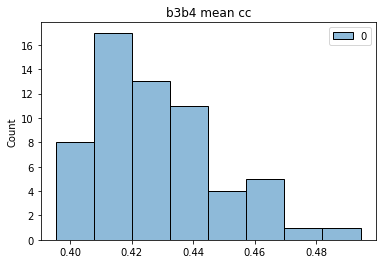

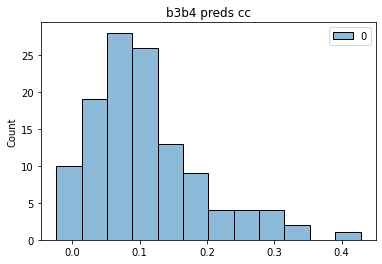

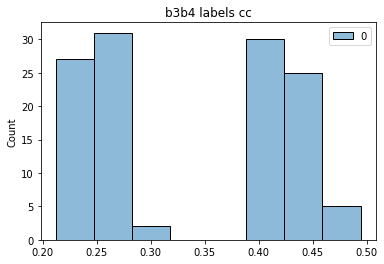

In [117]:
plt.figure()
sns.histplot(b4_cc_avg[0][0].reshape(-1, 1))
plt.title('b3b4 mean cc')


plt.figure()
sns.histplot(b3b4_oth_cc_train_preds)
plt.title('b3b4 preds cc')

plt.figure()
sns.histplot(b3b4_oth_labels_cc_train.cpu().numpy())
plt.title('b3b4 labels cc')


In [76]:

import utils 
importlib.reload(utils)


ppp('b3b4 degree features and CC labels CCA corr:')
get_cca_corr(b3b4_oth_degree_train_feat, b3b4_oth_cc_train_preds)
get_cca_corr(b3b4_oth_degree_train_preds, b3b4_oth_cc_train_feat)

ppp('b3b4 degree features and CC features:')
get_cca_corr(b3b4_oth_degree_train_feat, b3b4_oth_cc_train_feat)

ppp('b3b4 b3b4_oth_cc_train_feat and b3b4_oth_cc_dataloaders:')
get_cca_corr(b3b4_oth_cc_train_feat, b3b4_oth_cc_dataloaders[0][0].dataset.y.reshape(-1, 1))
get_cca_corr(b3b4_oth_cc_train_preds, b3b4_oth_cc_dataloaders[0][0].dataset.y.reshape(-1, 1))

get_cca_corr(b1b2_oth_cc_train_preds, b1b2_oth_cc_dataloaders[0][0].dataset.y.reshape(-1, 1))
get_cca_corr(b3b4_oth_degree_train_preds, b3b4_oth_degree_dataloaders[0][0].dataset.y.reshape(-1, 1))



------------------------------
b3b4 degree features and CC labels CCA corr:
r2: 0.07555246045822095
(-0.9987964362681205, 2.2835740873455306e-156)
r2: -801.3814815357264
(0.9995094082620025, 2.356490808808005e-179)
------------------------------
b3b4 degree features and CC features:
r2: -0.4929315973618502
(0.9999994908728957, 0.0)
------------------------------
b3b4 b3b4_oth_cc_train_feat and b3b4_oth_cc_dataloaders:
r2: 0.0006177509273761483
(0.4769712287461079, 3.639254410539658e-08)
r2: -0.981444181209713
(-0.00927790600776872, 0.9198896486033262)
r2: -0.6096532004390853
(-0.19517340311218204, 0.032660848563148756)
r2: 0.9325699648330888
(0.9662849824730843, 2.220436765181222e-71)


(80, 1)
(80,)
(80, 1)
(80,)
(80, 1)
(80,)
(80, 1)
(80,)
(80, 1)
(80,)
(80, 1)
(80,)
(80, 1)
(80,)
(80, 1)
(80,)


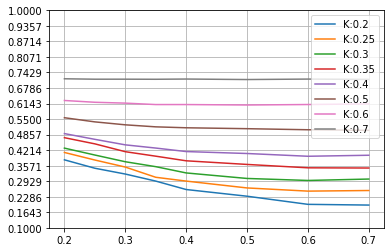

NameError: name 'b1b2' is not defined

In [85]:
# visualize:

# ----------------------------------------- b3b4
sample_each_num = 10
neighbor_list = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

ps = [0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

fig = plt.figure()
for p_cur in ps:
    neighbor_list = [p_cur for _ in range(len(ps))]
    # xs = neighbor_list
    xs = ps

    b3 = generate_ws_samples(sample_each_num, node_num=40, nei_num=neighbor_list, ps=ps)
    b3_adjs = b3[0]

    b3_degree = generate_node_feature([(b3_adjs, None, b3_adjs, None)], node_degree_feature)

    b3_degree_avg = np.mean(b3_degree[0][0], axis=1)
    b3_cc_avg =  generate_node_feature([(b3_adjs, None, b3_adjs, None)] ,node_cc_avg_feature)

    print(b3_degree_avg.shape)
    print(b3_cc_avg[0][0].shape)
    b3_degree_list = []
    b3_cc_list = []
    for i in range(len(xs)):
        b3_degree_list.append(np.mean(b3_degree_avg[i*sample_each_num: sample_each_num * (i+1)]))
        b3_cc_list.append(np.mean(b3_cc_avg[0][0].reshape(-1, 1)[i*sample_each_num: sample_each_num * (i+1)]))


# plt.plot(xs, b3_degree_list)
# plt.figure()
    plt.plot(xs, b3_cc_list, label=f'K:{p_cur}')

minor_ticks_top=np.linspace(0.1,1,15)
ax = fig.gca()

ax.set_yticks(minor_ticks_top)
# axes[0].set_xticks(minor_ticks_top,minor=True)
# axes[0].set_yticks(minor_ticks_top,minor=True)
# axes[0].set_title("Subplot 1")
# axes[0].grid(which="major",alpha=0.6)
# axes[0].grid(which="minor",alpha=0.3)


plt.legend()
plt.grid()
plt.show()

# plt.figure()
# sns.histplot(b3_degree_avg.reshape(-1, 1))
# plt.title('b3 mean degree')


# plt.figure()
# sns.histplot(b3_cc_avg[0][0].reshape(-1, 1))
# plt.title('b3 mean cc')


# ----------------------------------------- b1b2
# plt.figure()
# sns.histplot(b1_degree_avg[0].reshape(-1, 1))
# plt.title('b1 mean degree')

# plt.figure()
# sns.histplot(b2_degree_avg[0].reshape(-1, 1))
# plt.title('b2 mean degree')


# plt.figure()
# sns.histplot(b1_cc_avg[0][0].reshape(-1, 1))
# plt.title('b1 mean cc')

# plt.figure()
# sns.histplot(b2_cc_avg[0][0].reshape(-1, 1))
# plt.title('b2 mean cc')


* based on above figure, pick same horizontal points
- blueK=0.2, p=0.3, orangeK=0.25, p=0.35, greenK=0.3, p= 0.6,
- redK=0.35,p=0.6, orangek=0.25, p=0.3 (try this first)

(80, 1)
(80,)


Text(0.5, 1.0, 'b3 mean cc')

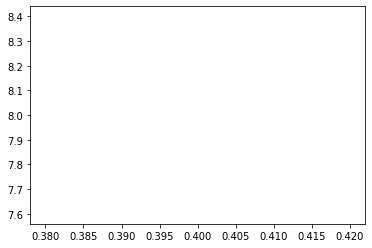

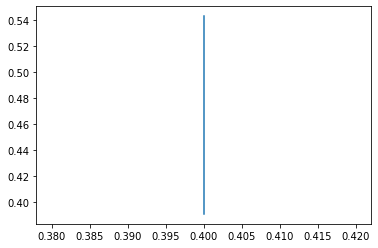

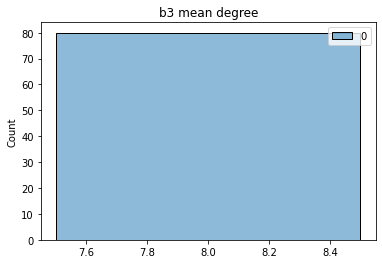

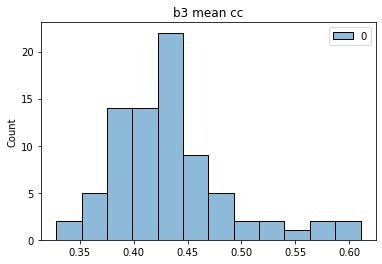

In [ ]:
# visualize:

# ----------------------------------------- b3b4
sample_each_num = 10
neighbor_list = [0.1, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

ps = [0.1, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7]
neighbor_list = [0.4 for _ in range(len(ps))]

xs = ps

b3 = generate_ws_samples(sample_each_num, nei_num=neighbor_list, ps=ps)
b3_adjs = b3[0]

b3_degree = generate_node_feature([(b3_adjs, None, b3_adjs, None)], node_degree_feature)

b3_degree_avg = np.mean(b3_degree[0][0], axis=1)
b3_cc_avg =  generate_node_feature([(b3_adjs, None, b3_adjs, None)] ,node_cc_avg_feature)

print(b3_degree_avg.shape)
print(b3_cc_avg[0][0].shape)
b3_degree_list = []
b3_cc_list = []
for i in range(len(neighbor_list)):
    b3_degree_list.append(np.mean(b3_degree_avg[i*sample_each_num: sample_each_num * (i+1)]))
    b3_cc_list.append(np.mean(b3_cc_avg[0][0].reshape(-1, 1)[i*sample_each_num: sample_each_num * (i+1)]))


plt.figure()
plt.plot(neighbor_list, b3_degree_list)
plt.figure()
plt.plot(neighbor_list, b3_cc_list)


plt.figure()
sns.histplot(b3_degree_avg.reshape(-1, 1))
plt.title('b3 mean degree')


plt.figure()
sns.histplot(b3_cc_avg[0][0].reshape(-1, 1))
plt.title('b3 mean cc')


# ----------------------------------------- b1b2
# sns.heatmap(b1_adjs_train[0])
# plt.figure()
# sns.heatmap(b2_adjs_train[0])


# plt.figure()
# sns.histplot(b1_degree_avg[0].reshape(-1, 1))
# plt.title('b1 mean degree')

# plt.figure()
# sns.histplot(b2_degree_avg[0].reshape(-1, 1))
# plt.title('b2 mean degree')


# plt.figure()
# sns.histplot(b1_cc_avg[0][0].reshape(-1, 1))
# plt.title('b1 mean cc')

# plt.figure()
# sns.histplot(b2_cc_avg[0][0].reshape(-1, 1))
# plt.title('b2 mean cc')



In [284]:

a = np.ones((3, 2, 2))
b = 2 * a

c= np.concatenate([a, b], axis=-1)
d= np.concatenate([b, a], axis=-1)
e = np.concatenate([c, d], axis=-2)
print(e[0])

[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]]


# Generate WS graph node feature

In [271]:
# construct node features:

# Try classification and regression tasks both and compare.
neighbor_list=[0.1, 0.3, 0.5, 0.7]
ps = [0.6,0.4,0.2,0.8]
class_num = len(neighbor_list)
data_ws = generate_ws_samples(60, nei_num=neighbor_list, ps=ps)
# data_ws = generate_ws_samples(60)
data_ws_regress = (data_ws[0], data_ws[1], data_ws[3], data_ws[4])
data_ws_classify = (data_ws[0], data_ws[2], data_ws[3], data_ws[5])

ws_regre_train_node_index_feas, ws_regre_test_node_index_feas = generate_node_feature([data_ws_regress], node_index_feature)
ws_class_train_node_index_feas, ws_class_test_node_index_feas = generate_node_feature([data_ws_classify], node_index_feature)
ws_class_train_node_cc_feas, ws_class_test_node_cc_feas = generate_node_feature([data_ws_regress], node_cc_feature)

In [272]:
ws_train_node_allone_feas, ws_test_node_allone_feas = generate_node_feature([data_ws_classify], node_allone_feature)

# add Gaussion noise:

ws_train_node_allone_feas[0] = ws_train_node_allone_feas[0] + np.random.random(size=ws_train_node_allone_feas[0].shape)
ws_test_node_allone_feas[0] = ws_test_node_allone_feas[0] + np.random.random(size=ws_test_node_allone_feas[0].shape)

# construct degree dataset:

In [273]:
# node-wise:
ws_degree_train_node_index_feas, ws_degreee_test_node_index_feas = generate_node_feature([data_ws_classify], node_degree_feature)

data_ws_degree = (data_ws[0], ws_degree_train_node_index_feas[0], data_ws[3], ws_degreee_test_node_index_feas[0])



In [274]:

# graph-level:

degree_mean_train = np.mean(ws_degree_train_node_index_feas[0], axis=1).squeeze()
degree_mean_test = np.mean(ws_degreee_test_node_index_feas[0], axis=1).squeeze()

data_ws_degree_graphwize = (data_ws[0], degree_mean_train, data_ws[3], degree_mean_test)


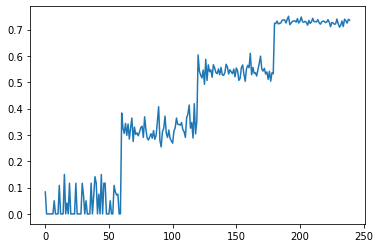

<Figure size 432x288 with 0 Axes>

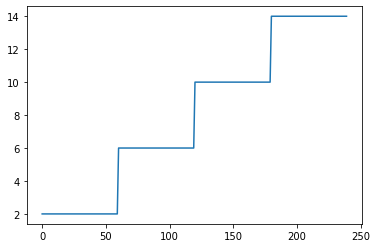

In [275]:
plt.plot(data_ws[1])
plt.figure()
plt.show()
plt.plot(degree_mean_train)
plt.show()

# construct node clustring coefficient label

In [257]:
ws_cc_dataloaders = []
data_ws_cc = (data_ws[0], ws_class_train_node_cc_feas[0], data_ws[3], ws_class_test_node_cc_feas[0])

ws_cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(data_ws_cc,
                        (ws_regre_train_node_index_feas[0], ws_regre_test_node_index_feas[0]), y_torch_type=torch.FloatTensor)))


# Generate WS graph dataloader

In [258]:
ws_regre_dataloaders = []
ws_regre_dataloaders.append(assemble_dataloader(
    *construct_dataset(data_ws_regress,
                        (ws_regre_train_node_index_feas[0], ws_regre_test_node_index_feas[0]), y_torch_type=torch.FloatTensor)))



ws_class_dataloaders = []
ws_class_dataloaders.append(assemble_dataloader(
    *construct_dataset(data_ws_classify,
                        (ws_class_train_node_index_feas[0], ws_class_test_node_index_feas[0]), y_torch_type=torch.LongTensor)))

In [259]:
# node-wise degree
ws_degree_dataloaders = []
train_datasets_degree, test_datasets_degree, nodewise_degree_scaler = construct_dataset(data_ws_degree,
                        (ws_class_train_node_index_feas[0], ws_class_test_node_index_feas[0]), norm=False, y_torch_type=torch.FloatTensor)

ws_degree_dataloaders.append(assemble_dataloader(train_datasets_degree, test_datasets_degree) )


In [260]:
# node-wise degree with all one vector features.
ws_degree_dataloaders = []
train_datasets_degree, test_datasets_degree, nodewise_degree_scaler = construct_dataset(data_ws_degree,
                        (ws_train_node_allone_feas[0], ws_test_node_allone_feas[0]), norm=True, y_torch_type=torch.FloatTensor)

ws_degree_dataloaders.append(assemble_dataloader(train_datasets_degree, test_datasets_degree) )


# Visualize the node degree histgram:

(4800, 1)


Text(0.5, 1.0, 'graphwise degree')

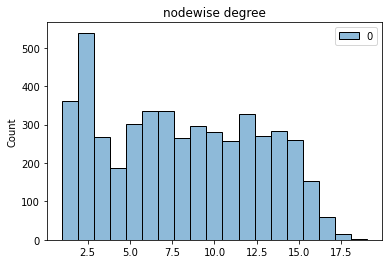

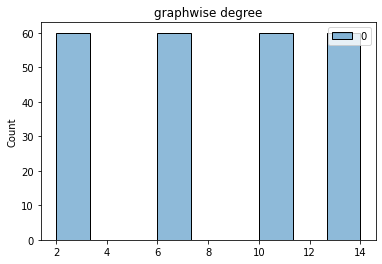

In [261]:
# train degree:

print(ws_degree_train_node_index_feas[0].reshape(-1, 1).shape)
sns.histplot(ws_degree_train_node_index_feas[0].reshape(-1, 1))
plt.title('nodewise degree')


# train degree:
plt.figure()
sns.histplot(degree_mean_train.reshape(-1, 1))
plt.title('graphwise degree')

In [25]:
# graph-wise degree, label: mean degree, feature: index.
ws_degree_graphwise_dataloaders = []
ws_degree_graphwise_dataloaders.append(assemble_dataloader(
    *construct_dataset(data_ws_degree_graphwize,
                        (ws_class_train_node_index_feas[0], ws_class_test_node_index_feas[0]), y_torch_type=torch.FloatTensor)))


In [26]:

# graph-wise degree, label: mean degree, feature: all one.
ws_degree_graphwise_allone_dataloaders = []
ws_degree_graphwise_allone_dataloaders.append(assemble_dataloader(
    *construct_dataset(data_ws_degree_graphwize,
                        (ws_train_node_allone_feas[0], ws_test_node_allone_feas[0]), y_torch_type=torch.FloatTensor)))


/li_zhengdao/github/GenerativeGNN/utils.py:186: RuntimeWarning: invalid value encountered in true_divide
  return (data - mean) / std


In [27]:
print(ws_regre_dataloaders[0][0].dataset.y.shape)
print(ws_degree_dataloaders[0][0].dataset.y.shape)
print(ws_degree_graphwise_dataloaders[0][0].dataset.y.shape)

torch.Size([120])


NameError: name 'ws_degree_dataloaders' is not defined

# Task1 :Train WS graph

In [28]:
# use degree node features:
import utils 
importlib.reload(utils)



args = utils.get_common_args()
args = args.parse_args({})

ws_gnn_evls = []
ws_gnn_evls_train = []
gnn_models = []
for train_dataloader, test_dataloader in ws_class_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=200,
                                    node_fea_dim=1,
                                    class_num=2,
                                    node_num=20,lr=0.001)
    gnn_models.append(cur_model)
    ws_gnn_evls_train.append(train_evl)
    ws_gnn_evls.append(test_evl)
    

Confusion: [[0.94 0.06]
 [0.02 0.98]]


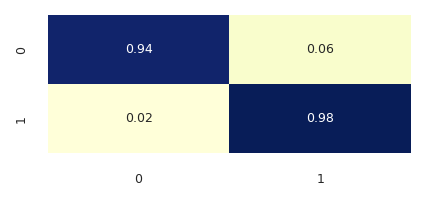

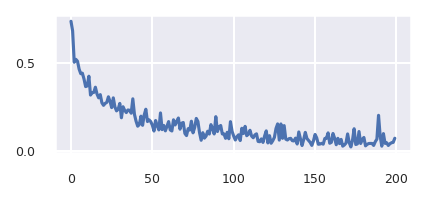

Confusion: [[0.88 0.12]
 [0.01 0.99]]


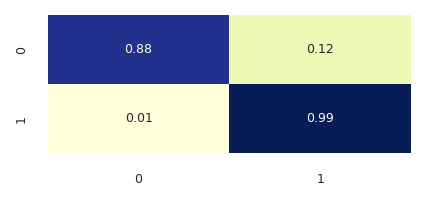

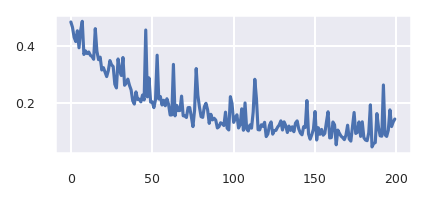

In [29]:
ws_gnn_evls_train[0].plot_metrics()
ws_gnn_evls[0].plot_metrics()

# Task2 :Regression Train WS graph

In [30]:
# use degree node features:
import utils 
importlib.reload(utils)


args = utils.get_common_args()
args = args.parse_args({})

ws_gnn_evls_regre = []
ws_gnn_evls_train_regre = []
gnn_models_task2 = []
for train_dataloader, test_dataloader in ws_degree_graphwise_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=100,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=20, lr=0.001, is_regression=True)
    gnn_models_task2.append(cur_model)
    ws_gnn_evls_train_regre.append(train_evl)
    ws_gnn_evls_regre.append(test_evl)

# task3: graph-Wise mean degree train

In [31]:
import utils 
importlib.reload(utils)


args = utils.get_common_args()
args = args.parse_args({})

ws_gnn_evls_train_graphwise_degree = []
ws_gnn_evls_graphwise_degree = []


# ws_degree_graphwise_allone_dataloaders
gnn_models_task3 = []
for train_dataloader, test_dataloader in ws_degree_graphwise_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=200,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=20, lr=0.0001, is_regression=True)
    gnn_models_task3.append(cur_model)
    ws_gnn_evls_train_graphwise_degree.append(train_evl)
    ws_gnn_evls_graphwise_degree.append(test_evl)

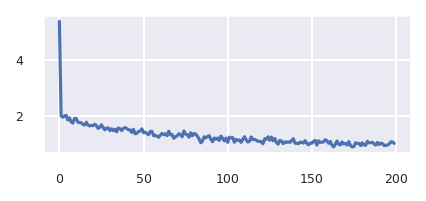

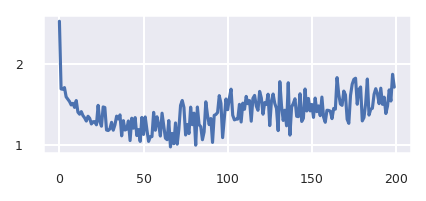

In [32]:
ws_gnn_evls_train_graphwise_degree[0].plot_metrics()
ws_gnn_evls_graphwise_degree[0].plot_metrics()

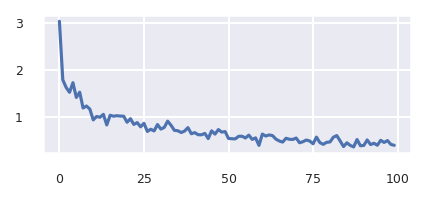

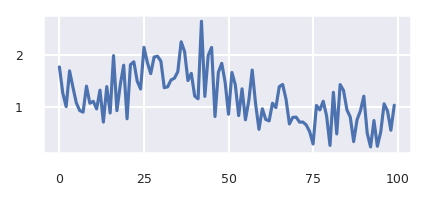

In [33]:
ws_gnn_evls_train_regre[0].plot_metrics()
ws_gnn_evls_regre[0].plot_metrics()

# CCA (Canical Component Analysis)

In [35]:
task1_train_feat = get_mid_feat(gnn_models[0],ws_class_dataloaders[0][0])
task1_test_feat = get_mid_feat(gnn_models[0],ws_class_dataloaders[0][1])

pooled_task1_feas_train = gnn_models[0].pooling(task1_train_feat).detach().cpu().numpy()
pooled_task1_feas_test = gnn_models[0].pooling(task1_test_feat).detach().cpu().numpy()

mid_feas shape torch.Size([120, 20, 32])
mid_feas shape torch.Size([40, 20, 32])


In [36]:
task2_train_feat = get_mid_feat(gnn_models_task2[0],ws_regre_dataloaders[0][0])
task2_test_feat = get_mid_feat(gnn_models_task2[0],ws_regre_dataloaders[0][1])

pooled_task2_feas_train = gnn_models_task2[0].pooling(task2_train_feat).detach().cpu().numpy()
pooled_task2_feas_test = gnn_models_task2[0].pooling(task2_test_feat).detach().cpu().numpy()

mid_feas shape torch.Size([120, 20, 32])
mid_feas shape torch.Size([40, 20, 32])


In [37]:
task3_train_feat = get_mid_feat(gnn_models_task3[0],ws_degree_graphwise_dataloaders[0][0])
task3_test_feat = get_mid_feat(gnn_models_task3[0],ws_degree_graphwise_dataloaders[0][1])

pooled_task3_feas_train = gnn_models_task3[0].pooling(task3_train_feat).detach().cpu().numpy()
pooled_task3_feas_test = gnn_models_task3[0].pooling(task3_test_feat).detach().cpu().numpy()

mid_feas shape torch.Size([120, 20, 32])
mid_feas shape torch.Size([40, 20, 32])


In [38]:
from sklearn.cross_decomposition import CCA

n_compo = 1

cca = CCA(n_components=n_compo, scale=True, max_iter=500, tol=1e-06, copy=True)
cca.fit(pooled_task1_feas_train, pooled_task2_feas_train)
X_c, Y_c = cca.transform(pooled_task1_feas_train, pooled_task2_feas_train)

r2 = cca.score(pooled_task1_feas_train, pooled_task2_feas_train)
print('r2:',r2)

r2: 0.021363008408520404


In [39]:
# cal correaltion:

from scipy import stats

corr = stats.pearsonr(X_c.squeeze(), Y_c.squeeze())
print(corr)

(0.8848933757636922, 5.808046257704263e-41)


In [40]:
from sklearn.cross_decomposition import CCA

n_compo = 1

cca = CCA(n_components=n_compo, scale=True, max_iter=500, tol=1e-06, copy=True)
cca.fit(pooled_task1_feas_train, pooled_task3_feas_train)
X_c, Y_c = cca.transform(pooled_task1_feas_train, pooled_task3_feas_train)

r2 = cca.score(pooled_task1_feas_train, pooled_task3_feas_train)
print('r2:',r2)

# cal correaltion:

from scipy import stats

corr = stats.pearsonr(X_c.squeeze(), Y_c.squeeze())
print(corr)

r2: 0.04313881907705289
(0.8802843247079198, 5.122818890577508e-40)


#  use task2, task3 features to Task1 model.

mid_feas shape torch.Size([40, 20, 32])
torch.Size([40, 32])
torch.Size([40])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
torch.Size([40])
Confusion: [[1.  0. ]
 [0.2 0.8]]


4

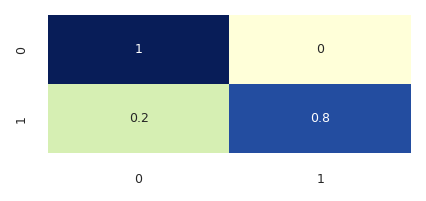

In [68]:
# get regression feature from classification dataloaders:

cur_model = gnn_models_task2[0]
cur_model.mid_fea = True
cur_model.eval()

test_dataloader_class = ws_class_dataloaders[0][1]
new_test_dataloader_class = DataLoader(test_dataloader_class.dataset, batch_size=10, shuffle=False,  collate_fn=test_dataloader_class.dataset.collate)


mid_feas = []
for x, _ in new_test_dataloader_class:
    x = x.cuda()
    _, mid_f = cur_model(x)
    mid_feas.append(mid_f)
mid_feas = torch.cat(mid_feas, dim=0)
print('mid_feas shape', mid_feas.shape)

pooled_mid_feas = cur_model.pooling(mid_feas)
print(pooled_mid_feas.shape)
print(new_test_dataloader_class.dataset.y.shape)

preds_by_task2_fea = gnn_models[0].ln(pooled_mid_feas).cuda()
preds_b = preds_by_task2_fea.argmax(dim=1).squeeze()
print(preds_b)

labels = new_test_dataloader_class.dataset.y

print(labels.shape)
plot_confuse_matrix(preds_b, labels)

4 

# Task4: node-wise cc and node-wise degree

In [149]:
# train node-wise cc:
import utils 
importlib.reload(utils)

args = utils.get_common_args()
args = args.parse_args({})

ws_gnn_evls_train_nodewise_cc = []
ws_gnn_evls_nodehwise_cc = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task4 = []
for train_dataloader, test_dataloader in ws_cc_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=20, lr=0.0001, is_regression=True, is_node_wise=True)
    
    gnn_models_task4.append(cur_model)
    ws_gnn_evls_train_nodewise_cc.append(train_evl)
    ws_gnn_evls_nodehwise_cc.append(test_evl)
    

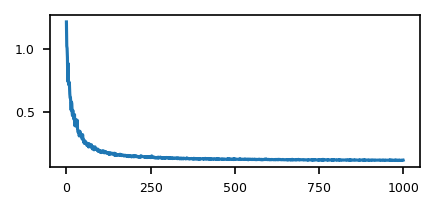

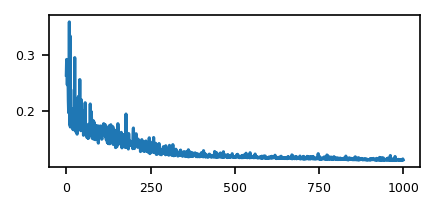

In [151]:
ws_gnn_evls_train_nodewise_cc[0].plot_metrics()
ws_gnn_evls_nodehwise_cc[0].plot_metrics()

In [227]:
# train node-wise degree:

import utils 
importlib.reload(utils)


args = utils.get_common_args()
args = args.parse_args({})

ws_gnn_evls_train_nodewise_degree = []
ws_gnn_evls_nodehwise_degree = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task5 = []
for train_dataloader, test_dataloader in ws_degree_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=500,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=20, lr=0.0001, is_regression=True, is_node_wise=True, loss_cal='mse',
                                    opt='sgd')
                                    # node_num=20, lr=0.0001, is_regression=True, is_node_wise=True, scaler=nodewise_degree_scaler)
    # if mse: lr = 0.0001 if mae: lr = 0.00005
    gnn_models_task5.append(cur_model)
    ws_gnn_evls_train_nodewise_degree.append(train_evl)
    ws_gnn_evls_nodehwise_degree.append(test_evl)
    

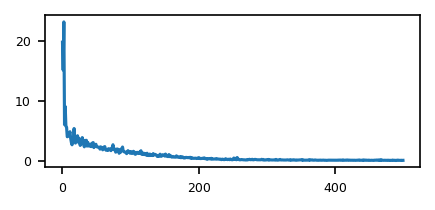

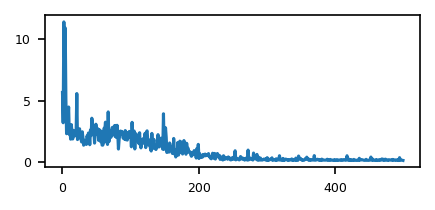

In [228]:
# ALL one vector:
ws_gnn_evls_train_nodewise_degree[0].plot_metrics()
ws_gnn_evls_nodehwise_degree[0].plot_metrics()

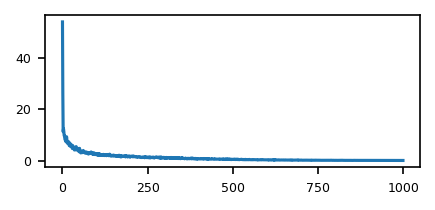

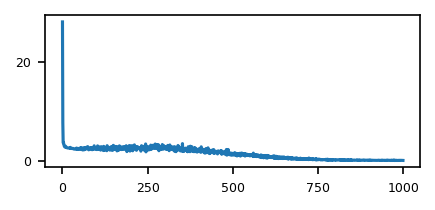

In [145]:
# MAE loss:
ws_gnn_evls_train_nodewise_degree[0].plot_metrics()
ws_gnn_evls_nodehwise_degree[0].plot_metrics()

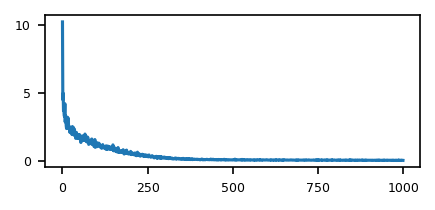

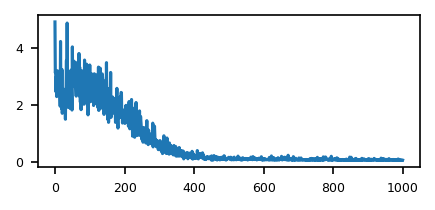

In [117]:
# MSE loss:
ws_gnn_evls_train_nodewise_degree[0].plot_metrics()
ws_gnn_evls_nodehwise_degree[0].plot_metrics()

# compare CCA of node-wise cc and degree

In [152]:
task4_train_feat = get_mid_feat(gnn_models_task4[0],ws_cc_dataloaders[0][0])
task4_test_feat = get_mid_feat(gnn_models_task4[0],ws_cc_dataloaders[0][1])


task5_train_feat = get_mid_feat(gnn_models_task5[0],ws_degree_dataloaders[0][0])
task5_test_feat = get_mid_feat(gnn_models_task5[0],ws_degree_dataloaders[0][1])


mid_feas shape torch.Size([120, 20, 32])
mid_feas shape torch.Size([40, 20, 32])
mid_feas shape torch.Size([120, 20, 32])
mid_feas shape torch.Size([40, 20, 32])


In [153]:
# flatten the node features.

task4_train_feat_flat = task4_train_feat.reshape(120*20, -1).detach().cpu().numpy()
task5_train_feat_flat = task5_train_feat.reshape(120*20, -1).detach().cpu().numpy()

get_cca_corr(task4_train_feat_flat, task5_train_feat_flat)

r2: -0.11561966029941728
(0.645535495612801, 4.919549807797992e-283)


# CCA Corr of node-wise degree and CC

# CCA corr of graph-wise degree and CC

In [263]:
# flatten the node features.
flat_cc = ws_class_train_node_cc_feas[0].reshape(-1, 1)
flat_degree = ws_degree_train_node_index_feas[0].reshape(-1, 1)

flat_cc_graphwise = data_ws[1].reshape(-1, 1)
flat_degree_graphwise = degree_mean_train.reshape(-1, 1)
print(flat_cc_graphwise.shape)
print(flat_degree_graphwise.shape)

get_cca_corr(flat_cc, flat_degree)
get_cca_corr(flat_cc_graphwise, flat_degree_graphwise)

(240, 1)
(240, 1)
r2: 0.7798066561508605
(0.889903326934605, 0.0)
r2: 0.9832510163361506
(0.9916255079555044, 1.4275435656896424e-213)


# fake a data to check the result:

In [154]:
# degree:

cur_model = gnn_models_task5[0]
cur_model.mid_fea = False

input_x = None
out_y = None
label_y = None
for x, y in ws_degree_dataloaders[0][0]:
    input_x = x
    label_y = y
    x = x.cuda()
    out = cur_model(x)
    print(out.shape)
    out_y = out.cpu()
    break



torch.Size([10, 20, 1])


In [338]:
adj_test = np.ones((40, 40))
adj_test[:,::2] = 0
adj_test[::2,:] = 0


adj_test[:,1::2] = 1
adj_test[1::2,:] = 1


x_1 = BaseGraphUtils.from_numpy(adj_test)
print(adj_test)

cur_model = gnn_models_task7[0]

x_1.set_node_feat(b1b2_scaler.transform(torch.ones(40, 1).float().numpy()+ np.random.random(size=(40, 1))))
x_1 = x_1.cuda()
bx = BaseGraphUtils.init_batch_graph([x_1])
out_x1 = cur_model(bx)
out_x1 = out_x1.cpu().detach().numpy()


print('predict:', out_x1.squeeze())


[[0. 1. 0. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
predict: 54.21732


# Check whether GNN can learn the CC ?

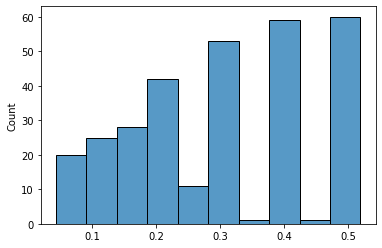

In [22]:
# Generate CC dataset ws graphs:

Ks=[0.1, 0.2, 0.3, 0.4, 0.5]
ps = [0.6 for _ in range(len(Ks))]
cc_graphs = generate_ws_samples(60, node_num=40, nei_num=Ks, ps=ps)
cc_adjs_train = cc_graphs[0]
cc_adjs_test = cc_graphs[3]

cc_graphs_avg_labels_train,  cc_graphs_avg_labels_test =  generate_node_feature([(cc_adjs_train, None, cc_adjs_test, None)] ,node_cc_avg_feature)
degree_graphs_avg_labels_train,  degree_graphs_avg_labels_test =  generate_node_feature([(cc_adjs_train, None, cc_adjs_test, None)] ,node_degree_feature)

degree_mean_train = np.mean(degree_graphs_avg_labels_train[0], axis=1).squeeze()
degree_mean_test = np.mean(degree_graphs_avg_labels_test[0], axis=1).squeeze()


cc_dataset = (cc_adjs_train, cc_graphs_avg_labels_train[0], cc_adjs_test, cc_graphs_avg_labels_test[0])

allone_train,  allone_test=  generate_node_feature([(cc_adjs_train, None, cc_adjs_test, None)], node_allone_feature)

# add Gaussion noise:
allone_train[0] = 0.1 * allone_train[0] + np.random.random(size=allone_train[0].shape)
allone_test[0] = 0.1 * allone_test[0] + np.random.random(size=allone_test[0].shape)
    
cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (allone_train[0], allone_test[0]), y_torch_type=torch.FloatTensor)))


# visualize histogram:

plt.figure()
sns.histplot(cc_graphs_avg_labels_train[0])
plt.show()


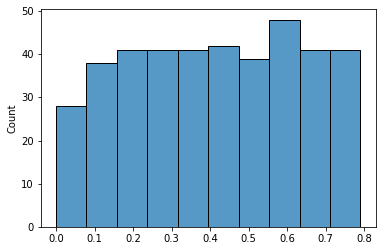

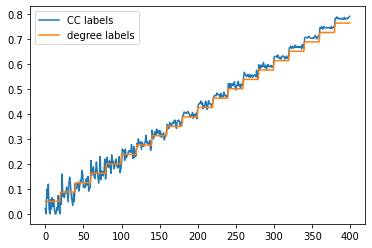

In [23]:
# NOTE: same Degree, different CC.

edge_nums = [40 + 30*i for i in range(20)]

cc_graphs = generate_gnm_samples(20, node_num=40, edge_nums=edge_nums)

cc_adjs_train = cc_graphs[0]
cc_adjs_test = cc_graphs[3]

cc_graphs_avg_labels_train,  cc_graphs_avg_labels_test =  generate_node_feature([(cc_adjs_train, None, cc_adjs_test, None)] ,node_cc_avg_feature)
degree_graphs_avg_labels_train,  degree_graphs_avg_labels_test =  generate_node_feature([(cc_adjs_train, None, cc_adjs_test, None)] ,node_degree_feature)

degree_mean_train = np.mean(degree_graphs_avg_labels_train[0], axis=1).squeeze()
degree_mean_test = np.mean(degree_graphs_avg_labels_test[0], axis=1).squeeze()


cc_dataset = (cc_adjs_train, cc_graphs_avg_labels_train[0], cc_adjs_test, cc_graphs_avg_labels_test[0])

allone_train,  allone_test=  generate_node_feature([(cc_adjs_train, None, cc_adjs_test, None)], node_allone_feature)

# add Gaussion noise:
allone_train[0] = 0.1 * allone_train[0] + np.random.random(size=allone_train[0].shape)
allone_test[0] = 0.1 * allone_test[0] + np.random.random(size=allone_test[0].shape)
    
cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (allone_train[0], allone_test[0]), y_torch_type=torch.FloatTensor)))


# visualize histogram:

plt.figure()
sns.histplot(cc_graphs_avg_labels_train[0])
plt.show()

plt.figure()
plt.plot(cc_graphs_avg_labels_train[0].reshape(-1, 1), label='CC labels')
plt.plot(degree_mean_train.reshape(-1, 1)/40, label='degree labels')
plt.legend()
plt.show()


(10, 10)
[3. 4. 5. 4. 4. 4. 4. 4. 4. 4.]


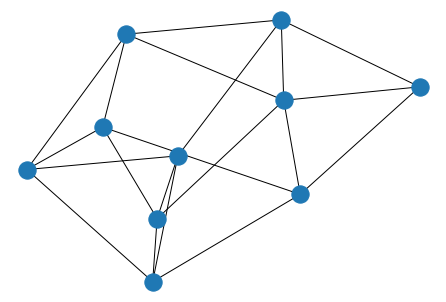

In [61]:


g = nx.triangular_lattice_graph(4,4)

# TODO: given degree, and CC generate ranwom graphs:

def generate_degree_CC_graphs(node_num, d, cc):
    # NOTE: use ws graph as bases:
    
    g = nx.watts_strogatz_graph(n=node_num, k=d, p=0.5)
    
    # get a center node, connect the neighbors:
    # by adj matrix: get the maximum degree node v, idx = Nei(v), then Nei(idx) \in idx, else: Nei(idx) \ idx_complement.
    
    adj = nx.to_numpy_array(g)
    print(adj.shape)
    max_degree_id = -1
    degrees = np.sum(adj, axis=0)
    print(degrees)
    return g
    
    
g = generate_degree_CC_graphs(10, d=5, cc=0.5)
    
nx.draw_spring(g)
plt.show()


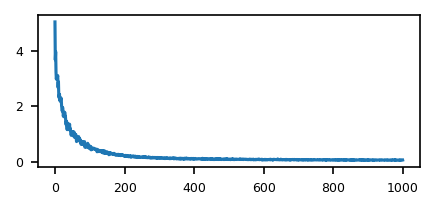

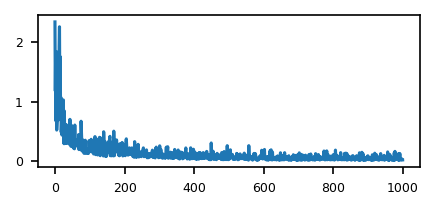

In [132]:
# Train corr(degree, CC) = 1:

import utils 
importlib.reload(utils)

args = utils.get_common_args()
args = args.parse_args({})

cc_gnn_evls_train = []
cc_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task11 = []
for train_dataloader, test_dataloader in cc_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.00001, is_regression=True, is_node_wise=False)
    
    gnn_models_task11.append(cur_model)
    cc_gnn_evls_train.append(train_evl)
    cc_gnn_evls_test.append(test_evl)
    
cc_gnn_evls_train[0].plot_metrics()
cc_gnn_evls_test[0].plot_metrics()

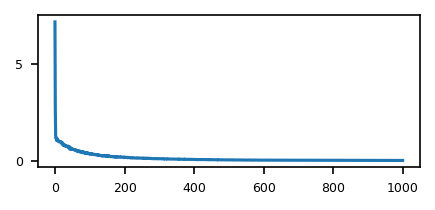

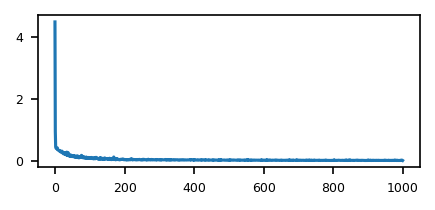

In [151]:
# Train corr(degree, CC) = 0:

import utils 
importlib.reload(utils)

args = utils.get_common_args()
args = args.parse_args({})

cc_gnn_evls_train = []
cc_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task11 = []
for train_dataloader, test_dataloader in cc_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.00001, is_regression=True, is_node_wise=False)
    
    gnn_models_task11.append(cur_model)
    cc_gnn_evls_train.append(train_evl)
    cc_gnn_evls_test.append(test_evl)
    
cc_gnn_evls_train[0].plot_metrics()
cc_gnn_evls_test[0].plot_metrics()

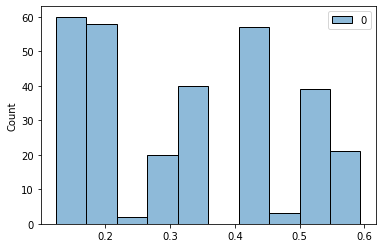

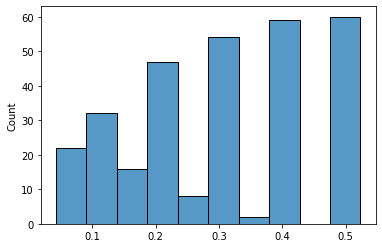

r2: 0.9777147275757168
(0.9888573645028, 1.4535963773063046e-248)


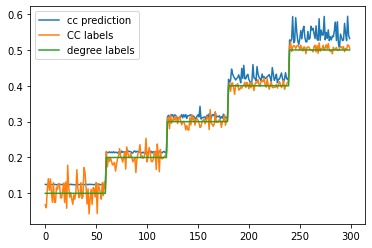

In [146]:
# test: corr(degree, CC) = 1:

cc_preds = get_mid_feat(gnn_models_task11[0], cc_dataloaders[0][0], prediction=True, logit=False)

# histogram:
plt.figure()
sns.histplot(cc_preds)
plt.show()

plt.figure()
sns.histplot(cc_graphs_avg_labels_train[0])
plt.show()

get_cca_corr(cc_graphs_avg_labels_train[0].reshape(-1, 1), cc_preds.reshape(-1, 1))


plt.figure()
plt.plot(cc_preds.reshape(-1, 1), label='cc prediction')
plt.plot(cc_graphs_avg_labels_train[0].reshape(-1, 1), label='CC labels')
plt.plot(degree_mean_train.reshape(-1, 1)/40, label='degree labels')
plt.legend()
plt.show()

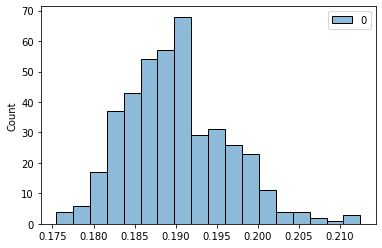

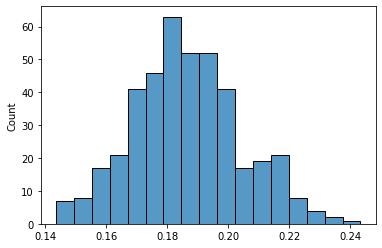

r2: -0.8755787501994421
(0.062210618923080094, 0.20324121186135974)


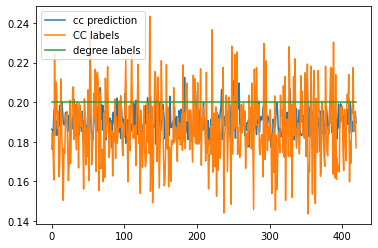

In [153]:
# test: corr(degree, CC) = 0:
cc_preds = get_mid_feat(gnn_models_task11[0], cc_dataloaders[0][0], prediction=True, logit=False)

# histogram:
plt.figure()
sns.histplot(cc_preds)
plt.show()

plt.figure()
sns.histplot(cc_graphs_avg_labels_train[0])
plt.show()

get_cca_corr(cc_graphs_avg_labels_train[0].reshape(-1, 1), cc_preds.reshape(-1, 1))

plt.figure()
plt.plot(cc_preds.reshape(-1, 1), label='cc prediction')
plt.plot(cc_graphs_avg_labels_train[0].reshape(-1, 1), label='CC labels')
plt.plot(degree_mean_train.reshape(-1, 1)/40, label='degree labels')
plt.legend()
plt.show()




# generate CC historgram with same degree
# cc without degree correlation bias



<class 'numpy.matrix'>


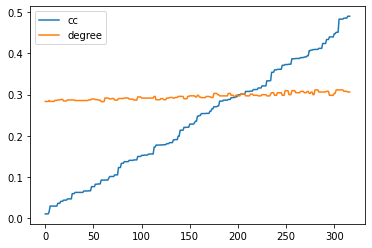

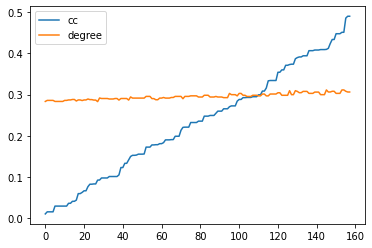

In [24]:
import utils
importlib.reload(utils)

import networkx as nx
from functools import reduce


cc_train_adjs, cc_train_y, cc_test_adjs, cc_test_y = generate_cc_no_degree_corr_samples(cc_range_num=20)
# random add edges:
# add E edges, repeat for 5 times.
print(type(cc_train_adjs[0].todense()))

data_graphs = [(cc_train_y[i],np.mean(np.sum(cc_train_adjs[i].todense(), axis=1))) for i in range(len(cc_train_adjs))]

data_graphs_s = sorted(data_graphs, key=lambda x: x[0])

ccs = [d[0] for d in data_graphs_s]
degrees = [d[1]/10 for d in data_graphs_s]

plt.figure()
plt.plot(ccs, label='cc')
plt.plot(degrees, label='degree')
plt.legend()
plt.show()

data_graphs = [(cc_test_y[i],np.mean(np.sum(cc_test_adjs[i].todense(), axis=1))) for i in range(len(cc_test_adjs))]

data_graphs_s = sorted(data_graphs, key=lambda x: x[0])

ccs_test = [d[0] for d in data_graphs_s]
degrees_test = [d[1]/10 for d in data_graphs_s]

plt.figure()
plt.plot(ccs_test, label='cc')
plt.plot(degrees_test, label='degree')
plt.legend()
plt.show()


# construct CC without degree-correlation biases

In [25]:
# Shuffle, and then split.
# cc_train_adjs, cc_train_y, cc_test_adjs, cc_test_y

cc_degree_avg_labels_train,  cc_degree_avg_labels_test =  generate_node_feature([(cc_train_adjs, None, cc_test_adjs, None)] ,node_degree_feature,
                                                                                sparse=True)


cc_degree_mean_train = np.stack([np.mean(cc_deg) for cc_deg in cc_degree_avg_labels_train[0]]).reshape(-1, 1)
cc_degree_mean_test = np.stack([np.mean(cc_deg) for cc_deg in cc_degree_avg_labels_test[0]]).reshape(-1, 1)

cc_dataset = (cc_train_adjs, cc_train_y, cc_test_adjs, cc_test_y)

allone_train,  allone_test=  generate_node_feature([(cc_train_adjs, None, cc_test_adjs, None)], node_allone_feature,
                                                   sparse=True)

# # # add Gaussion noise:

allone_train = [0.2 * allone_train[0][i] + np.random.random(size=allone_train[0][i].shape) for i in range(len(allone_train[0]))]
allone_test = [0.2 * allone_test[0][i] + np.random.random(size=allone_test[0][i].shape) for i in range(len(allone_test[0]))]


cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (allone_train, allone_test), y_torch_type=torch.FloatTensor, sparse=True), cuda=False))


# train via IDGIN
- 2022.08.21

In [26]:
# TODO: code:

# Train corr(degree, CC) = 0:
# NOTE: mean pool
import models
import utils
importlib.reload(utils)
importlib.reload(models)

args = utils.get_common_args()
args = args.parse_args({})

cc_gnn_evls_train = []
cc_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task11 = []
for train_dataloader, test_dataloader in cc_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='sparse_gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.0001, is_regression=True, is_node_wise=False)
    
    gnn_models_task11.append(cur_model)
    cc_gnn_evls_train.append(train_evl)
    cc_gnn_evls_test.append(test_evl)
    
cc_gnn_evls_train[0].plot_metrics()
cc_gnn_evls_test[0].plot_metrics()

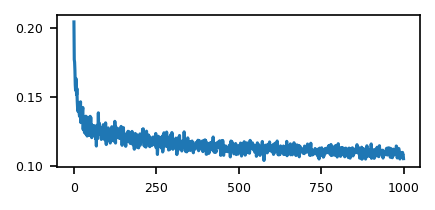

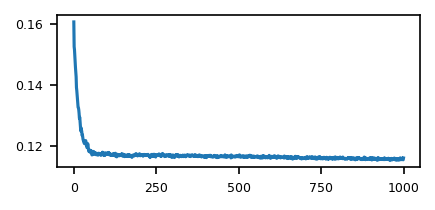

In [106]:
# Train corr(degree, CC) = 0:
# NOTE: mean pool
import models
import utils
importlib.reload(utils)
importlib.reload(models)

args = utils.get_common_args()
args = args.parse_args({})

cc_gnn_evls_train = []
cc_gnn_evls_test = []

# ws_degree_graphwise_allone_dataloaders
gnn_models_task11 = []
for train_dataloader, test_dataloader in cc_dataloaders:
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name='sparse_gin',
                                    epoch=1000,
                                    node_fea_dim=1,
                                    class_num=1,
                                    node_num=40, lr=0.0001, is_regression=True, is_node_wise=False)
    
    gnn_models_task11.append(cur_model)
    cc_gnn_evls_train.append(train_evl)
    cc_gnn_evls_test.append(test_evl)
    
cc_gnn_evls_train[0].plot_metrics()
cc_gnn_evls_test[0].plot_metrics()

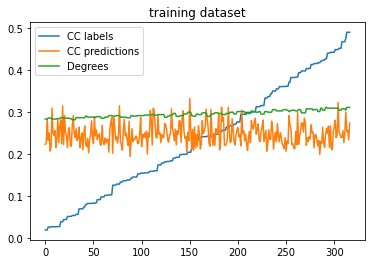

0.062097859946110445
0.048254643118343765
0.11821206502344155
0.11481394218452438


In [112]:
# NOTE: node feature mean: 0.2
cc_train_preds  = get_mid_feat(gnn_models_task11[0], cc_dataloaders[0][0], prediction=True, logit=False)

plt.figure()
plt.plot(ccs, label='CC labels')
plt.plot(cc_train_preds, label='CC predictions')
plt.plot(degrees, label='Degrees')
plt.title('training dataset')
plt.legend()
plt.show()

print(np.mean(degrees) - np.mean(ccs))
print(np.mean(degrees) - np.mean(cc_train_preds))

print(np.mean(np.abs(np.array(degrees) - np.array(ccs))))
print(np.mean(np.abs(np.array(ccs) - np.array(cc_train_preds))))


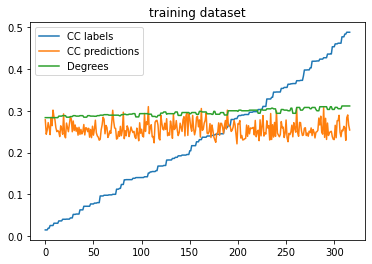

0.06694252976814438


In [95]:
# NOTE: node feature mean: 0.1

cc_train_preds  = get_mid_feat(gnn_models_task11[0], cc_dataloaders[0][0], prediction=True, logit=False)

plt.figure()
plt.plot(ccs, label='CC labels')
plt.plot(cc_train_preds, label='CC predictions')
plt.plot(degrees, label='Degrees')
plt.title('training dataset')
plt.legend()
plt.show()


print(np.mean(degrees) - np.mean(ccs))
print(np.mean(degrees) - np.mean(cc_train_preds))


# check the correctness of dataset

<class 'models.BaseGraph'>
index of sample: 0
index of sample: 40
index of sample: 80
index of sample: 120
index of sample: 160
index of sample: 200
index of sample: 1
index of sample: 41
index of sample: 81
index of sample: 121
index of sample: 161
index of sample: 201
index of sample: 2
index of sample: 42
index of sample: 82
index of sample: 122
index of sample: 162
index of sample: 202


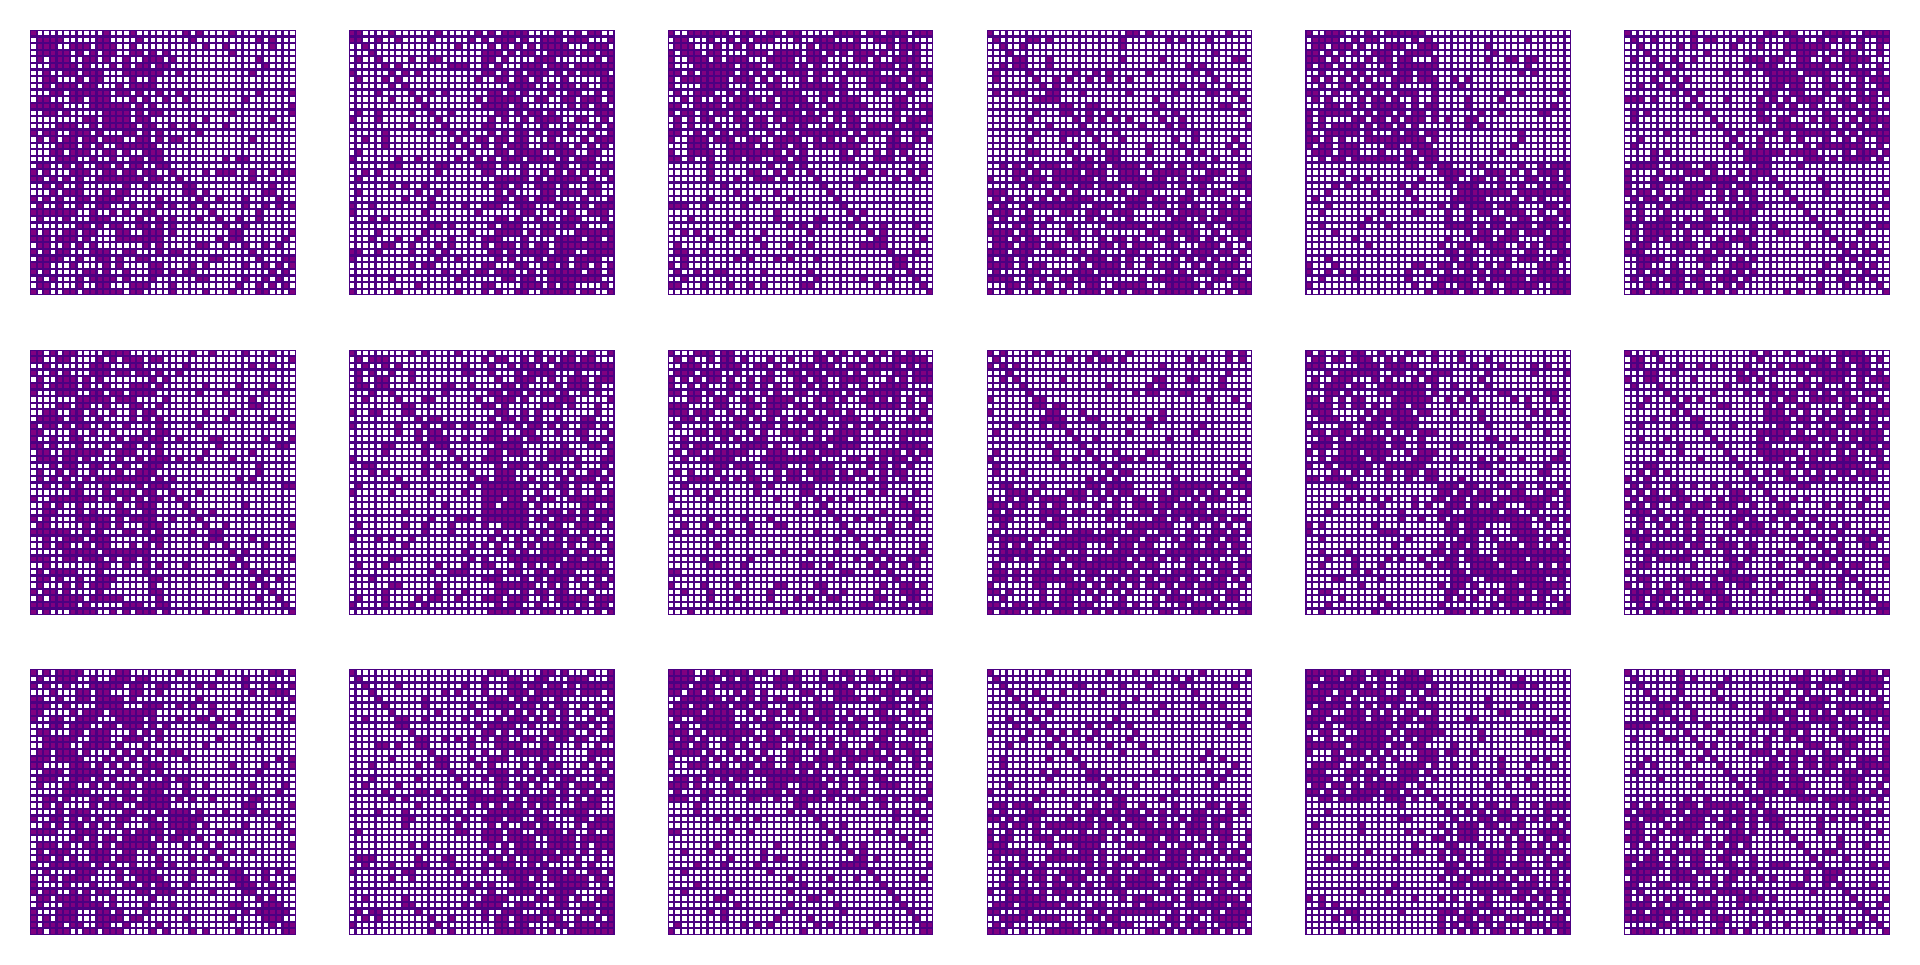

In [26]:
# TODO: check the density?



fig, axes = plt.subplots(3, 6, figsize=(8, 4), dpi=300)

train_dl, _ = dataloaders[5]
x_samples = train_dl.dataset.x
print(type(x_samples[0]))

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        index =  int(each_class_num) * j + i
        print('index of sample:', index)
        sns.heatmap(x_samples[index].A.cpu().numpy(), cbar=False, linecolor='indigo', square=True, linewidths=0.3,
                         cmap=ListedColormap(['white', 'purple']), ax=axes[i, j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.axis('off')
# ax.grid()
plt.show()


In [33]:
# plot f1 curves:

def get_f1s(evls):
    mi_f1 = []
    ma_f1 = []
    w_f1 = []

    for evl in evls:
        mi_f1.append(evl.total_metrics['micro_f1'])
        ma_f1.append(evl.total_metrics['macro_f1'])
        w_f1.append(evl.total_metrics['weighted_f1'])
    return mi_f1, ma_f1, w_f1

    
    
def plot_f1_curves(mi_f1, ma_f1, w_f1):
    plt.figure(figsize=(4, 3), dpi=150)


    x = np.linspace(0, 1, 24)
    plt.plot(x, mi_f1,  marker="8")
    plt.plot(x, ma_f1,  marker=11)
    ax = plt.axes()
  
# Setting the background color of the plot 
# using set_facecolor() method
    ax.set_facecolor("snow")
    
    plt.grid()
    plt.show()

# plot performance of WS classification

0.537


ValueError: x and y must have same first dimension, but have shapes (24,) and (1,)

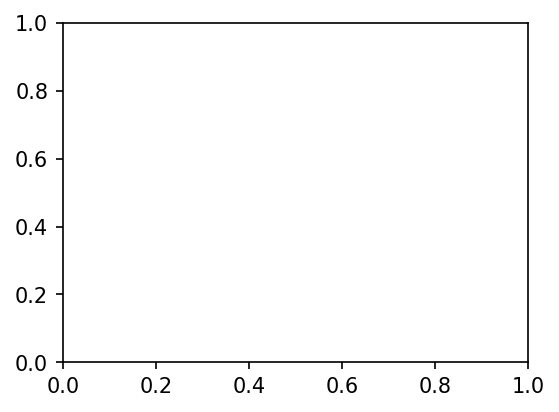

In [35]:
mi_f1, ma_f1, w_f1 = get_f1s(ws_gnn_evls)

print(mi_f1[0])
plot_f1_curves(mi_f1, ma_f1, w_f1)

In [ ]:
# combine wanted node features

# case: 1 only use index feas.

# case: 2, add allone vector can detect structural information:

train_combined_feature = composite_node_features(train_node_index_feas, train_node_allone_feas, train_node_std_feas)
test_combined_feature = composite_node_features(test_node_index_feas, test_node_allone_feas, test_node_std_feas)


In [ ]:

pos_en_dim = 10

dataloaders = []
for i, d in enumerate(data_sim):
    dataloaders.append(assemble_dataloader(
        *construct_dataset(d,
                           (train_combined_feature[i], test_combined_feature[i]), 
                                                              lap_encode=True,
                                                              lap_en_dim=pos_en_dim)))
    

In [ ]:
# NOTE: set the feature dimensions:

node_feature_dim = train_combined_feature.shape[-1]
graph_feature_dim = 1

print('node fea dim:', node_feature_dim)

node fea dim: 3


In [ ]:
# try again TODO: plot the performance curve.

# 2. train by each method:

# MLP:

mlp_evls = []

for train_dataloader, test_dataloader in dataloaders:
    _, test_evl = train_mlp(train_dataloader, test_dataloader, epoch=100)
    mlp_evls.append(test_evl)


mi_f1, ma_f1, w_f1 = get_f1s(mlp_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)

NameError: name 'mlp_evls' is not defined

# train LSPE

In [ ]:
import utils
import importlib
importlib.reload(utils)



def train_lspe(train_loader, test_loader, node_fea_dim, epoch=1, plot=False, model_name='lspe', graph_fea_dim=1):
# use CNN to trian:
    args = base_args()
    lspe_model = choose_model(model_name, node_fea_dim=node_fea_dim, graph_fea_dim=graph_fea_dim)
    # opt = optim.Adam(mlp_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    opt = optim.SGD(lspe_model.parameters(), lr=0.0001)
    ce_loss_cal = CELossCal()

    trainer = utils.Trainer(lspe_model, optimizer=opt, loss_cal=ce_loss_cal)
    train_sim_evl= SimpleEvaluator(args)
    test_sim_evl= SimpleEvaluator(args)

    training(epoch, trainer, train_sim_evl, test_sim_evl,train_loader,test_loader)
    if plot:
        train_sim_evl.plot_metrics()
        test_sim_evl.plot_metrics()
        
    return train_sim_evl, test_sim_evl
    
# t_dl, v_dl = dataloaders[0]
# _, _ = train_lspe(t_dl, v_dl, epoch=100, plot=True)
# train_cnn(inva_train_dataloader, inva_test_dataloader, True)

# node feature dim=3, added std feature



# Train LSPE

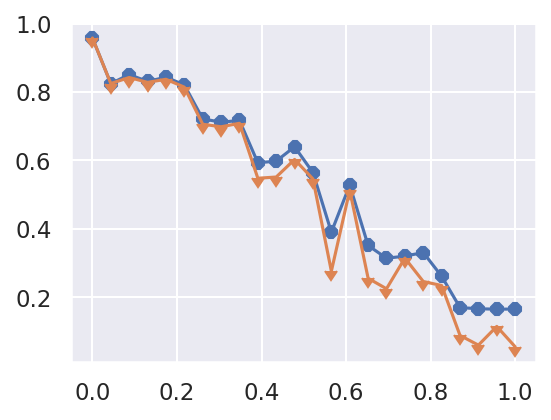

In [ ]:
# NOTE: LSPE:
# NOTE: 6 classification

val_lspe_evls = []
train_lspe_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_lspe(train_dataloader, test_dataloader, node_fea_dim=node_feature_dim, model_name='lspe', epoch=100)
    val_lspe_evls.append(test_evl)
    train_lspe_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(val_lspe_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)
    

In [ ]:
a = torch.ones(12).reshape(3, 4)
a.size(0)

3

# train CNN:

In [ ]:
cnn_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_cnn(train_dataloader, test_dataloader, epoch=100, graph_fea_dim=graph_feature_dim)
    cnn_evls.append((train_evl,test_evl))
    

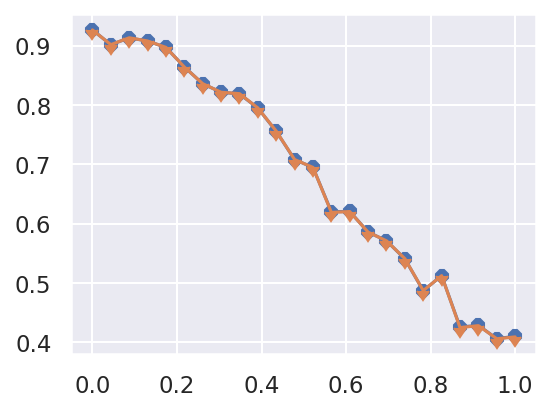

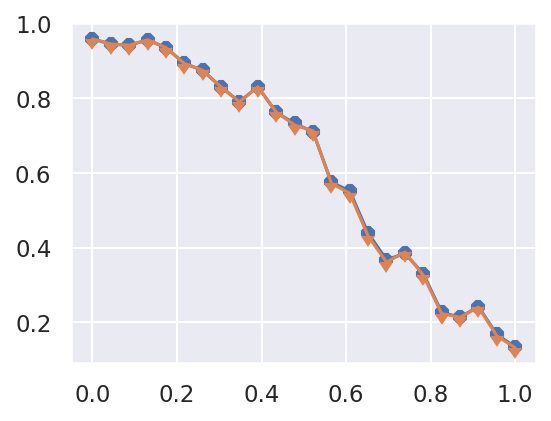

In [ ]:
# node feature dim=3, added std feature

train_cnn_evls = [e[0] for e in cnn_evls]
test_cnn_evls = [e[1] for e in cnn_evls]

mi_f1, ma_f1, w_f1 = get_f1s(train_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


mi_f1, ma_f1, w_f1 = get_f1s(test_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)

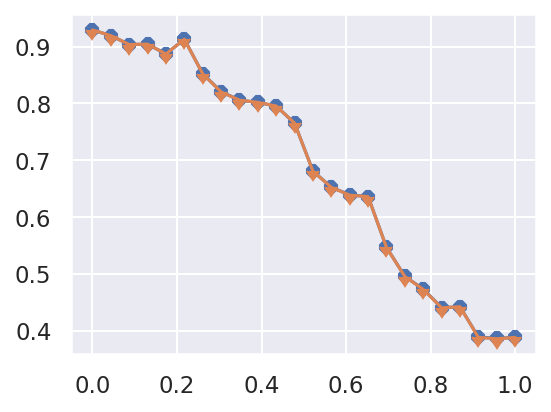

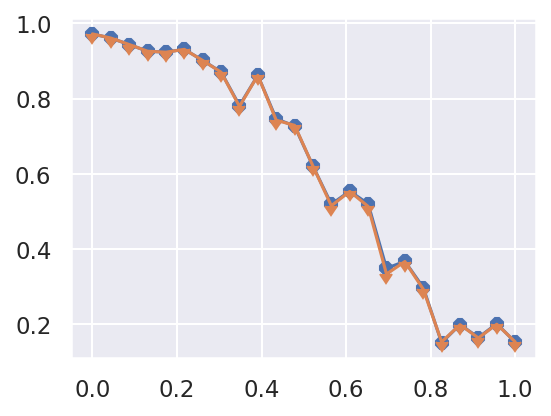

In [ ]:
# node feature dim=2

train_cnn_evls = [e[0] for e in cnn_evls]
test_cnn_evls = [e[1] for e in cnn_evls]

mi_f1, ma_f1, w_f1 = get_f1s(train_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


mi_f1, ma_f1, w_f1 = get_f1s(test_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)

In [ ]:
# plot confusion:
# visualize the train loader:

# node feature dim=2


train_cnn_evls[4].plot_metrics()


train_dl, _ = dataloaders[4]


fig, axes = plt.subplots(3, 4, figsize=(8, 6), dpi=150)

x_samples = train_dl.dataset.x
print(x_samples[0][1].shape)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        index =  4*i+j
        print('index of sample:', index)
        sns.heatmap(x_samples[index][1].cpu().numpy(), cbar=False, linecolor='indigo', square=True, linewidths=0.3,
                         cmap=ListedColormap(['white', 'purple']), ax=axes[i, j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.axis('off')
# ax.grid()
plt.show()



NameError: name 'train_cnn_evls' is not defined

# train GIN with lspe:

In [ ]:
# use degree node features:
import utils
import importlib
importlib.reload(utils)

args = utils.get_common_args()

args = args.parse_args({})
args.pos_en = 'lap_pe'
args.pos_en_dim = pos_en_dim

gnn_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin', epoch=200, node_fea_dim=node_feature_dim)
    gnn_evls.append(test_evl)
    
# node feature dim=3, added std feature

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


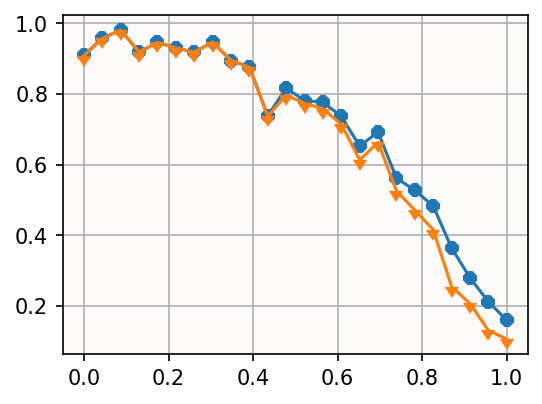

In [ ]:

mi_f1, ma_f1, w_f1 = get_f1s(gnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)

# train GNN without laspe

In [ ]:
# use degree node features:

gnn_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader, gnn_name='gnn', epoch=200, node_fea_dim=node_feature_dim)
    gnn_evls.append(test_evl)
    

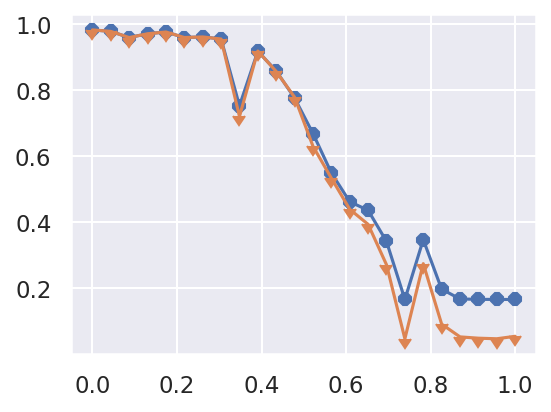

In [ ]:
# node feature dim=3, added std feature

mi_f1, ma_f1, w_f1 = get_f1s(gnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)



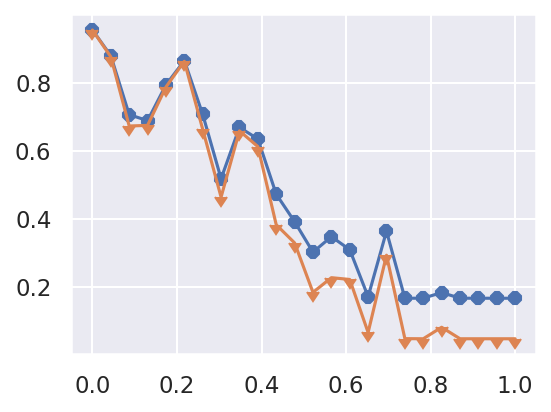

In [ ]:
# node feature dim=2

mi_f1, ma_f1, w_f1 = get_f1s(gnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)



Confusion: [[0.   0.6  0.09 0.17 0.   0.14]
 [0.   0.61 0.05 0.34 0.   0.  ]
 [0.   0.05 0.95 0.   0.   0.  ]
 [0.   0.06 0.01 0.93 0.   0.  ]
 [0.   0.6  0.04 0.35 0.   0.  ]
 [0.   0.38 0.16 0.13 0.   0.34]]


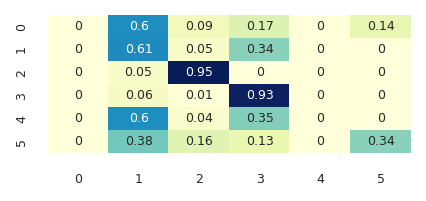

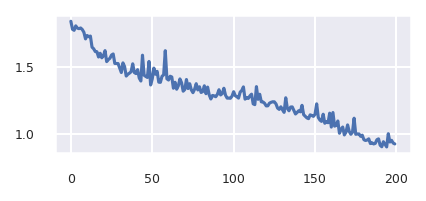

In [ ]:
# plot confusion:
# plot loss function:

evl = gnn_evls[10]
evl.plot_metrics()



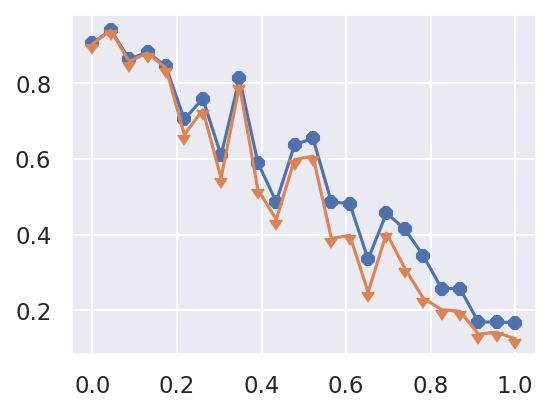

In [ ]:
# MLP gin:
# NOTE: 6 classification

gin_evls = []
train_gin_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader,
                                    node_fea_dim=node_feature_dim, gnn_name='gin', epoch=100)
    gin_evls.append(test_evl)
    train_gin_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)
    

Confusion: [[0.94 0.   0.01 0.   0.01 0.03]
 [0.   0.98 0.   0.   0.01 0.01]
 [0.   0.   0.97 0.   0.01 0.02]
 [0.02 0.05 0.   0.91 0.02 0.01]
 [0.   0.03 0.05 0.03 0.88 0.01]
 [0.38 0.16 0.14 0.09 0.01 0.23]]


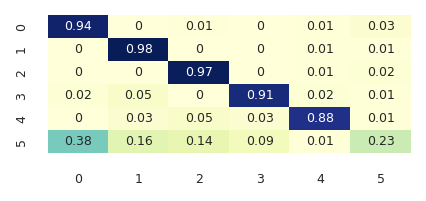

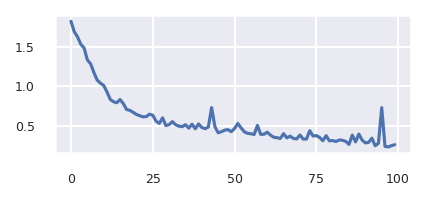

In [ ]:
# plot confusion:
# plot loss function:

evl = gin_evls[15]
evl.plot_metrics()



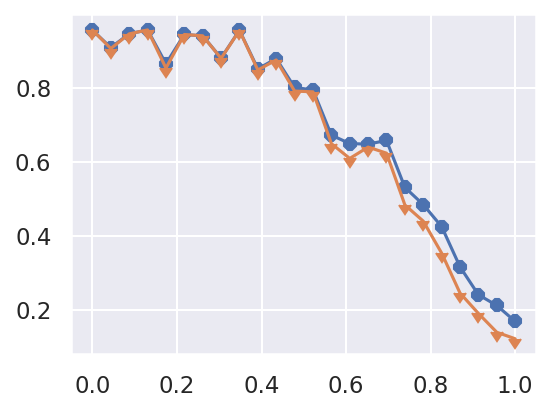

In [ ]:
# MLP gin:
# NOTE: 6 classification, 

# NOTE node feature dim=3, added std feature

gin_evls = []
train_gin_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader, 
                                    node_fea_dim=node_feature_dim, gnn_name='gin', epoch=100)
    gin_evls.append(test_evl)
    train_gin_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)
    

# Di GIN
# NOTE:use both direction:
# NOTE: 6 classification, 3 features, direct
# NOTE: added lap_en:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


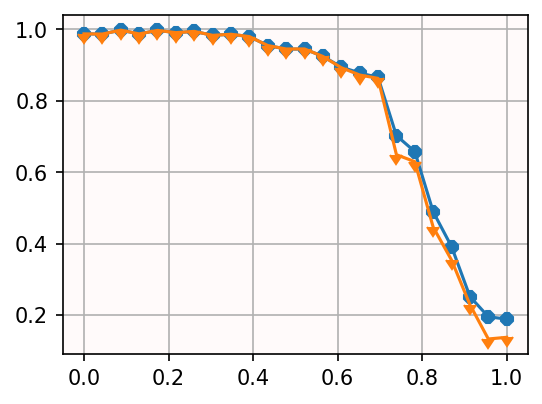

Confusion: [[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.98 0.01 0.   0.01]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.03 0.97 0.  ]
 [0.   0.02 0.   0.   0.   0.98]]


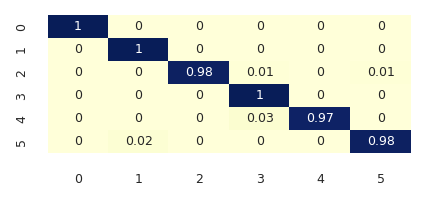

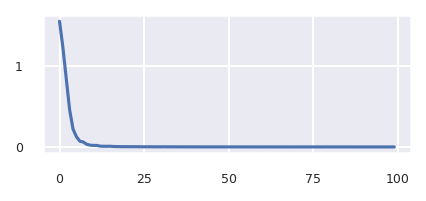

Confusion: [[0.97 0.   0.02 0.01 0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.03 0.03 0.94 0.   0.   0.  ]
 [0.   0.   0.   0.98 0.01 0.01]
 [0.   0.02 0.   0.   0.97 0.01]
 [0.   0.09 0.   0.03 0.   0.87]]


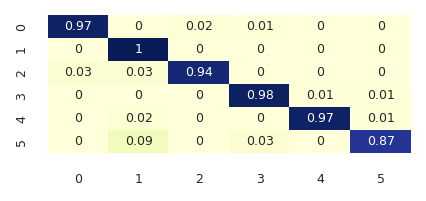

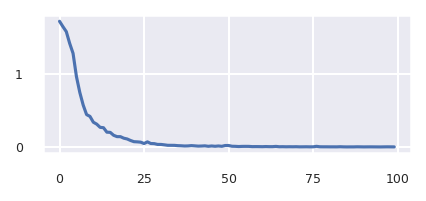

Confusion: [[0.99 0.   0.   0.01 0.   0.  ]
 [0.02 0.91 0.   0.05 0.02 0.  ]
 [0.05 0.   0.95 0.01 0.   0.  ]
 [0.   0.   0.01 0.96 0.02 0.  ]
 [0.05 0.   0.   0.03 0.92 0.  ]
 [0.27 0.11 0.05 0.04 0.   0.54]]


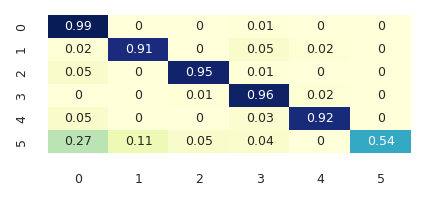

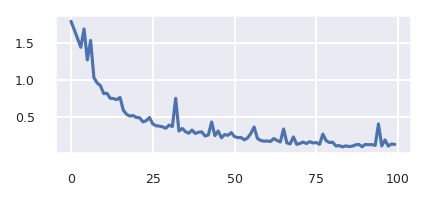

In [ ]:
# use both direction:
# NOTE: 6 classification, 3 features, direct
# NOTE: added lap_en:
 

args = utils.get_common_args()

args = args.parse_args({})
args.pos_en = 'lap_pe'
args.pos_en_dim = pos_en_dim

gin_evls = []
train_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(args, train_dataloader, test_dataloader,
                                    gnn_name='gin_direc', epoch=100, node_fea_dim=node_feature_dim)
    gin_evls.append(test_evl)
    train_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


evl = gin_evls[1]
evl.plot_metrics()

evl = gin_evls[10]
evl.plot_metrics()

evl = gin_evls[15]
evl.plot_metrics()


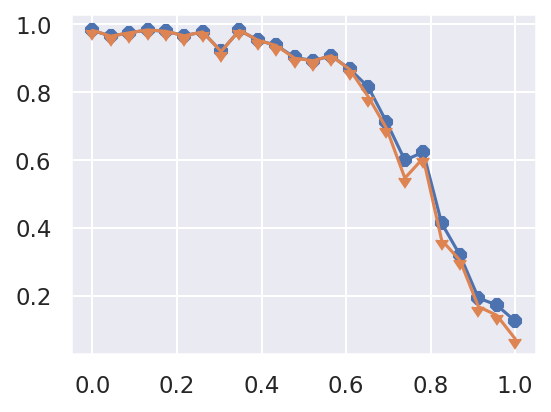

Confusion: [[0.94 0.   0.   0.   0.   0.06]
 [0.   0.98 0.   0.   0.02 0.  ]
 [0.01 0.   0.97 0.   0.01 0.  ]
 [0.   0.   0.   0.99 0.   0.01]
 [0.   0.05 0.01 0.   0.93 0.  ]
 [0.02 0.   0.   0.   0.   0.97]]


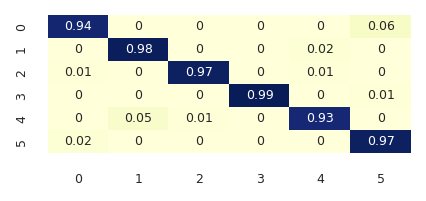

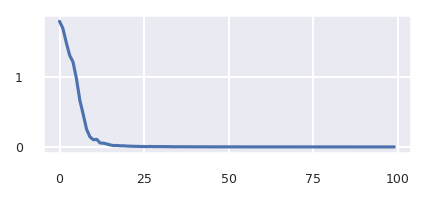

Confusion: [[0.97 0.   0.   0.02 0.01 0.  ]
 [0.   0.97 0.02 0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.  ]
 [0.01 0.   0.   0.98 0.   0.01]
 [0.07 0.01 0.04 0.   0.87 0.01]
 [0.03 0.02 0.06 0.01 0.03 0.84]]


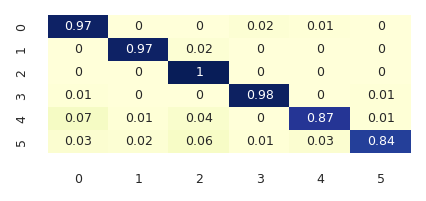

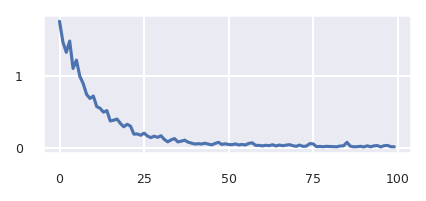

Confusion: [[0.94 0.   0.01 0.   0.01 0.03]
 [0.   0.98 0.   0.   0.01 0.01]
 [0.   0.   0.97 0.   0.01 0.02]
 [0.02 0.05 0.   0.91 0.02 0.01]
 [0.   0.03 0.05 0.03 0.88 0.01]
 [0.38 0.16 0.14 0.09 0.01 0.23]]


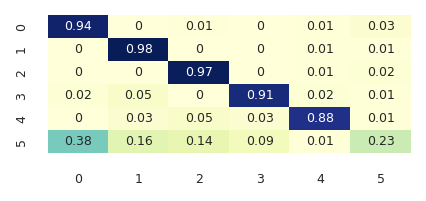

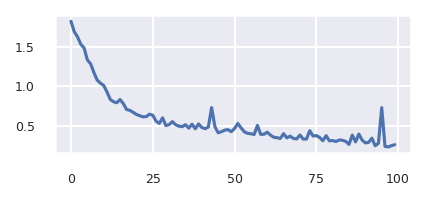

In [ ]:
# use both direction:
# NOTE: 6 classification
gin_evls = []
train_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader,gnn_name='gin_direc', epoch=100, node_fea_dim=node_feature_dim)
    gin_evls.append(test_evl)
    train_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


evl = gin_evls[1]
evl.plot_metrics()

evl = gin_evls[10]
evl.plot_metrics()

evl = gin_evls[15]
evl.plot_metrics()


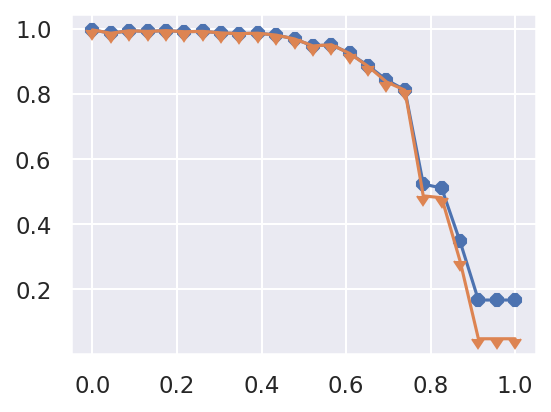

Confusion: [[0.98 0.   0.   0.   0.01 0.01]
 [0.   0.99 0.   0.   0.01 0.  ]
 [0.01 0.   0.99 0.   0.   0.  ]
 [0.   0.   0.01 0.99 0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.02 0.   0.97]]


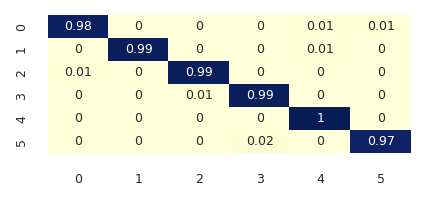

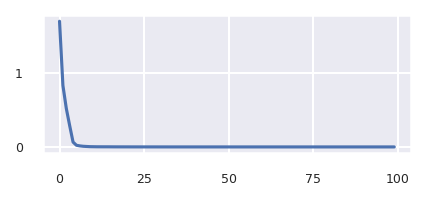

Confusion: [[1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.99 0.   0.   0.  ]
 [0.   0.01 0.   0.99 0.   0.  ]
 [0.   0.01 0.   0.02 0.97 0.  ]
 [0.02 0.03 0.01 0.   0.   0.94]]


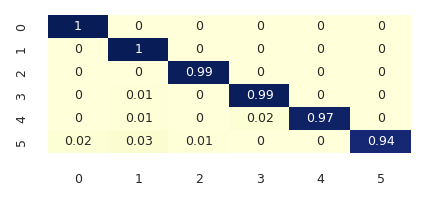

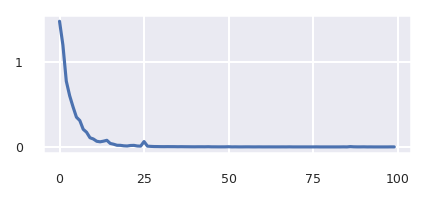

Confusion: [[0.95 0.   0.   0.02 0.01 0.02]
 [0.   0.96 0.01 0.   0.02 0.01]
 [0.01 0.01 0.97 0.   0.   0.01]
 [0.   0.   0.   0.99 0.   0.01]
 [0.01 0.01 0.   0.11 0.75 0.11]
 [0.06 0.   0.   0.14 0.09 0.7 ]]


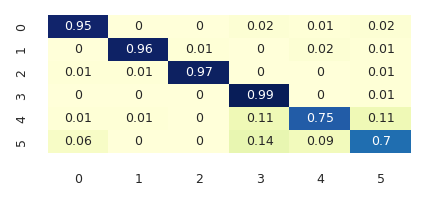

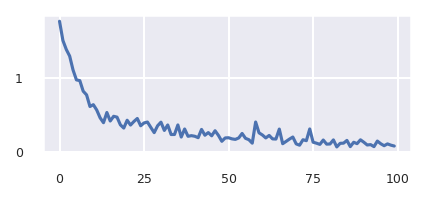

In [ ]:
# use both direction:
# NOTE: 6 classification
# NOTE: 3 node features !!

gin_evls = []
train_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader,gnn_name='gin_direc', epoch=100, node_fea_dim=node_feature_dim)
    gin_evls.append(test_evl)
    train_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


evl = gin_evls[1]
evl.plot_metrics()

evl = gin_evls[10]
evl.plot_metrics()

evl = gin_evls[15]
evl.plot_metrics()


In [ ]:
# TODO: concate the allone features and index features, not together training.





In [ ]:
# try laplacian
# construct new features:


utils.calculate_normalized_laplacian()







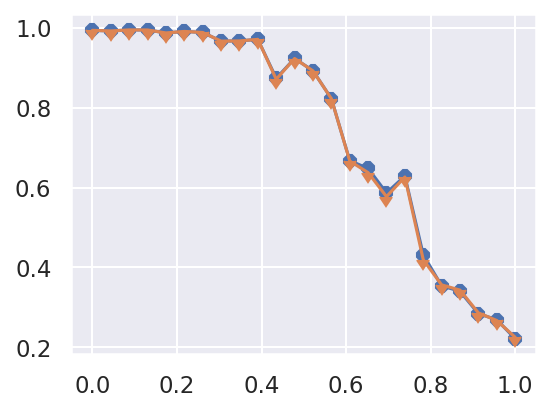

In [ ]:
big_kernel_cnn_evls = []
for train_dataloader, test_dataloader in dataloaders:
    _, test_evl = train_cnn(train_dataloader, test_dataloader, epoch=200, cnn_name='cnn_big')
    big_kernel_cnn_evls.append(test_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(big_kernel_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)
    

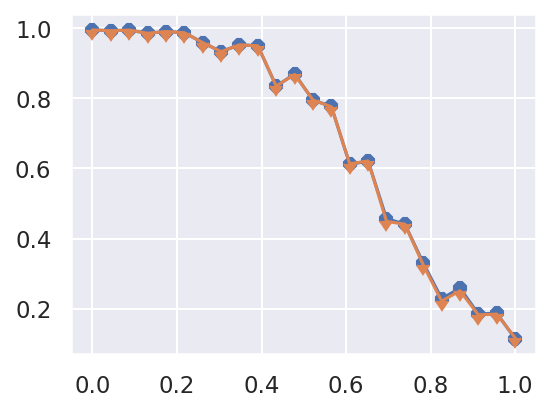

In [ ]:
# NOTE: 6 class:

big_kernel_cnn_evls = []
cnn_train_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_cnn(train_dataloader, test_dataloader, epoch=200, cnn_name='cnn_big')
    big_kernel_cnn_evls.append(test_evl)
    cnn_train_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(big_kernel_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


# Try Real-world dataset from PyG generic datasets
website: `https://pytorch-geometric.readthedocs.io/en/latest/notes/data_cheatsheet.html`

* graph classification:
    * TUDataset
    * ZINC

## TODO: 
1. use. # due: 6.30.
2. profile. # due: 7.1.

In [33]:
# TODO: 1. how to use them.
# classTUDataset


import torch_geometric.datasets as pygdataset


tudataset = pygdataset.tu_dataset.TUDataset(root='/li_zhengdao/github/GenerativeGNN/dataset/', name='AIDS')





Extracting /li_zhengdao/github/GenerativeGNN/dataset/AIDS/AIDS.zip
Processing...
Done!


In [34]:
a = tudataset.get(1)
a.y
print(type(a))

# TODO: transform to BaseGraph

<class 'torch_geometric.data.data.Data'>


In [62]:
import models
import importlib
from models import BaseGraphUtils
importlib.reload(models)


refresh_import()

tu_base_graphs = []
for a in tudataset:
    tu_base_graphs.append(BaseGraphUtils.from_pyg_graph(a))

In [63]:
tu_y = []
for g in tu_base_graphs:
    tu_y.append(g.label)
tu_y = torch.stack(tu_y, dim=0).squeeze()

train_tu_dataset = GraphDataset(x=tu_base_graphs, y=torch.LongTensor(tu_y))

In [72]:
import utils
import importlib
import models
from models import GraphDataset

importlib.reload(utils)
importlib.reload(models)


train_x, train_y, test_x, test_y = utils.random_split_dataset(train_tu_dataset, [0.8, 0.2])

print(len(train_x))
from collections import Counter
tr_y = Counter(train_y.numpy())
print(tr_y)

tu_train_dataset = GraphDataset(x=train_x, y=train_y)
tu_test_dataset = GraphDataset(x=test_x, y=test_y)

tu_train_dataloader, tu_test_dataloader = assemble_dataloader(tu_train_dataset, tu_test_dataset)


1600
Counter({1: 1280, 0: 320})


In [73]:
gg =train_tu_dataset.x[0]
print(gg.graph_type)

pyg


In [74]:
# NOTE: torch.LongTensor(0) will always fail !!!!!!!!!!!!!!!!!
a = torch.from_numpy(np.array([0.0])).long()
d = torch.LongTensor(1).repeat(10).reshape(10, 1)
b = np.repeat(np.array([0]), 11)
c =torch.from_numpy(b).long().reshape(11, 1)

print(d.squeeze().shape)
print(c.squeeze().shape)
print(torch.cat([d, c], dim=0).shape)

torch.Size([10])
torch.Size([11])
torch.Size([21, 1])


In [79]:
for x, y in tu_train_dataloader:
    print(x.batch_num)
    print(y.shape)
    print(x.adj_type)
    print(x.pyg_graph.num_nodes)
    break

10
torch.Size([10])
coo
130


In [97]:
# profiling

# TUDataset.
# NOTE node feature dim=3, added std feature


args = utils.get_common_args()

args = args.parse_args({})
args.pos_en = 'lap_pe'
args.pos_en_dim = pos_en_dim


gin_evls = []
train_gin_evls = []
train_evl, test_evl = train_gnn(args, tu_train_dataloader, tu_test_dataloader, 
                                    node_fea_dim=node_feature_dim, gnn_name='lsd_gin', epoch=100)
gin_evls.append(test_evl)
train_gin_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

print(mi_f1[0])
print(ma_f1[0])
print(w_f1[0])
plot_f1_curves(mi_f1, ma_f1, w_f1)
    

N: 129
tensor(128)
torch.Size([2, 270])


RuntimeError: Could not run 'aten::to_dense' with arguments from the 'CPU' backend. 'aten::to_dense' is only available for these backends: [MkldnnCPU, SparseCPU, SparseCUDA, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

MkldnnCPU: registered at /pytorch/build/aten/src/ATen/MkldnnCPUType.cpp:144 [kernel]
SparseCPU: registered at /pytorch/build/aten/src/ATen/SparseCPUType.cpp:239 [kernel]
SparseCUDA: registered at /pytorch/build/aten/src/ATen/SparseCUDAType.cpp:320 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:7586 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:7586 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:7586 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:7586 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:7586 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:7586 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:7586 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_4.cpp:9291 [kernel]
Autocast: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:254 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/BatchingRegistrations.cpp:511 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


In [96]:

i = torch.tensor([[0,1,2,3,2], [0,1,2, 2,0]])
 
# 指定坐标上的值
v = torch.tensor([1,2,3,3, 1])
 
a = torch.sparse_coo_tensor(indices=i, values=v, size=[4, 4])
print(a)


tensor(indices=tensor([[0, 1, 2, 3, 2],
                       [0, 1, 2, 2, 0]]),
       values=tensor([1, 2, 3, 3, 1]),
       size=(4, 4), nnz=5, layout=torch.sparse_coo)


# draw confusion map

Confusion: [[1.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.  ]
 [0.   0.01 0.99 0.   0.   0.  ]
 [0.   0.   0.   0.99 0.   0.01]
 [0.   0.   0.   0.   0.99 0.  ]
 [0.   0.   0.   0.   0.   0.99]]


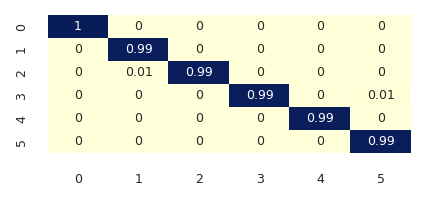

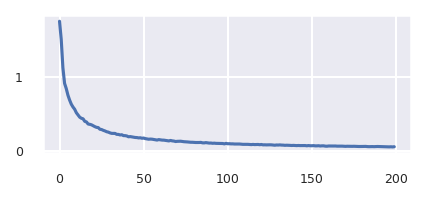

Confusion: [[0.9  0.   0.06 0.   0.04 0.  ]
 [0.   0.9  0.09 0.01 0.   0.  ]
 [0.   0.08 0.76 0.   0.08 0.08]
 [0.09 0.02 0.   0.78 0.   0.1 ]
 [0.06 0.   0.15 0.01 0.77 0.  ]
 [0.   0.08 0.   0.01 0.   0.9 ]]


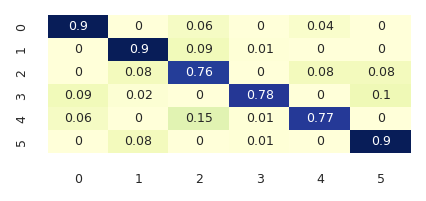

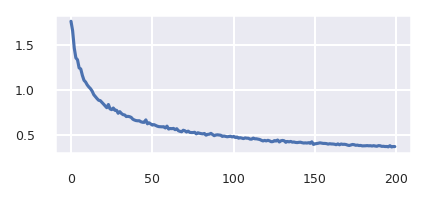

In [ ]:

evl = big_kernel_cnn_evls[1]
evl.plot_metrics()

evl = big_kernel_cnn_evls[10]
evl.plot_metrics()



# try GCN + GNN. involve more spectral information.



# incorporate the spectral methods:




In [ ]:
# TODO: transform data, and construct node features.
# construct pipline for the data.
# like transform object in cv.


def trans_spectral(d_loader):
    
    


# TODO:
# in future, add node feature, distinguish topological feature
* add temporal information to node features.
* add non-tological related node features.

In [ ]:
# TODO:





# How to train a probabilistic model

# compare graph similarity in spectra domain

In [ ]:
from pygsp import graphs, filters
import numpy as np


G = graphs.Logo()
G.compute_fourier_basis()  # Fourier to plot the eigenvalues.
 # G.estimate_lmax() is otherwise sufficient.


In [ ]:
g = filters.Heat(G, tau=50)

DELTAS = [20, 30, 1090]
s = np.zeros(G.N)
s[DELTAS] = 1
s = g.filter(s)
print(s)
G.plot_signal(s, highlight=DELTAS)


In [ ]:
from numpy import linalg

# # construct G:

def normlized_laplacian(adj):
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)
    normalized_laplacian = np.eye(adj.shape[0]) - np.matmul(np.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)
    return normalized_laplacian

eigs = [linalg.eig(normlized_laplacian(adj)) for adj in samples]


fig, axes = plt.subplots(3, 4, figsize=(8, 6), dpi=100)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i, j].plot(eigs[3*i+j][0].squeeze())


# d = np.array(adj.sum(1))
# d_inv_sqrt = np.power(d, -0.5).flatten()
# d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
# d_mat_inv_sqrt = sp.diags(d_inv_sqrt).toarray()
# normalized_laplacian = sp.eye(adj.shape[0]) - np.matmul(np.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)
# return normalized_laplacian